# Main Code Notebook
Reproducing main results for "Personalizing AI Interventions in Multiple Health Behavioral Change Settings"

Note that we expect that this code file will be uploaded to Google Colab and then the _notebook_code.zip will be uploaded separately (as its own zip), as per our instructions below.

## Setup: Import Packages and Modules

---



In [34]:
# import python packages
import numpy as np
import pandas as pd
from collections import defaultdict
import os
import time
import sys

Get access to code folder that this notebook references:

1. Upload the notebook_code.zip folder:

* In Colab, click the folder icon (left sidebar) to open the file explorer.

* Click the upload icon (📁) to upload the notebook_code folder (as a .zip file).

* Move the notebook_code folder into the content folder

2. Unzip the folder:

In [ ]:
!unzip notebook_code.zip -d _notebook_code

Archive:  _notebook_code.zip
 extracting: _notebook_code/__init__.py  
  inflating: _notebook_code/__pycache__/estimators.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/multichain_utils.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/progchain_ai.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/progchainworld.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/rl_utils.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/sample_traj.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/sample_traj_q_learning.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/sample_traj_stuck_est.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/vis_episodic_learning.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/vis_inter_stats.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/vis_inter_stats_w_stuck_est.cpython-312.pyc  
  inflating: _notebook_code/__pycache__/vis_plots_utils.cpython-312.pyc  
  inflating: _notebook_code/e

3. Add the module folder to the Python path:

In [ ]:
sys.path.append('/content/notebook_folder')

Import from helper code

In [37]:
from _notebook_code.rl_utils import value_iteration, state_to_index, index_to_state
from _notebook_code.progchainworld import make_nchains_transitions_simplified, make_rewards_stuck
from _notebook_code.sample_traj import sample_trajectory
from _notebook_code.vis_inter_stats import human_easier_vs_harder_n_ts_end_boxplots, plot_freq_n_timesteps_compar_from_config, AI_only_metric_boxplots_solid_colors
from _notebook_code.vis_plots_utils import vis_vary_f1_f2_other_heatmap_1scale_pol
from _notebook_code.progchain_ai import build_T_ai, build_R_ai
from _notebook_code.sample_traj_stuck_est import sample_trajectory_under_iter_est, sample_trajectory_under_seq_est
from _notebook_code.vis_inter_stats_w_stuck_est import plot_n_inters_ts_outcome_freq_outcome_compar_seq_iter
from _notebook_code.sample_traj_q_learning import sample_traj_q_learning_episodic_decay
from _notebook_code.vis_episodic_learning import plot_qlearning_v_oracle_stuck_freq_mk_goal, plot_qlearning_v_oracle_stuck_n_interventions


The following sections of this code notebook are ordered according to our 3 results sections in the corresponding paper (sections 3-5).

Note: throughout this notebook and our included code, we stuck chain and disengagement chain interchangeabely.  (s^{(S)} = s^{(D)}).  We also use relapse chain i interchangeably with b_i (the probability of moving back on progress chain i when not working on it).

## Modeling Human Decision-Making in MHBC Settings

Sampling human trajectories under human optimal policy, saving data for determining policy class and frequency of reaching goal versus dropping out.

In [ ]:
def mk_run_progchainworld(chain_1_dim: int, chain_2_dim: int, stuck_chain_dim: int,
                          p_fwd_chain_1: float, p_fwd_chain_2: float,
                          relapse_chain_1: float, relapse_chain_2: float,
                          p_fwd_stuck: float, p_back_stuck: float,
                          r_goal: float, r_dropout: float, gamma: float, delta_vi: float,
                          sample_trajectories: bool, n_trajectories: int, n_steps: int,
                          df: pd.DataFrame, iteration: int, print_none: bool, save_folder: str, save_file: str):
    """
    Helper function for instantiating a human multiprogress chainworld
    and repeatedly sampling human trajectories from it.  Logs metrics
    and statistics from sampled trajectory to a df.

    Parameters:
    -----------
    chain_1_dim, chain_2_dim, stuck_chain_dim: ints
        length of progress chain 1, progress chain 2, and disengagement chain
    p_fwd_chain_1, p_fwd_chain_2, relapse_chain_1, relapse_chain_2: floats in [0, 1]
        f_1, f_2, b_1, b_2 as defined in paper
    p_fwd_stuck, p_back_stuck: floats in [0, 1]
        f_d, b_d as defined in paper
    r_goal, r_dropout: floats
        r_g and r_d as defined in paper: reward for reaching goal state s_g and 
        dropout state s_d, respectively
    gamma, delta_vi: floats
        discount factor and threshold for convergence for value iteration
    sample_trajectories, n_trajectories, n_steps: bool, ints
        whether to sample trajectories (if True: samples n_trajectories trajectories,
        each of length n_steps timesteps)
    df, iteration: pd.DataFrame, int
        DataFrame to append data to (should have column names of 'column_names' variable
        in the cell block below), iteration of sampling trajectories
    print_none: bool
        if True: silences print to speed up running code
    save_folder, save_file: strs
        directory and .csv file name to save the logged statistics from sampling
        trajectories to (logged in the inputted df)
    """
    if not print_none:
        print("Probability of moving forward on chain 1 is {}\n".format(p_fwd_chain_1))
        print("Probability of moving forward on chain 2 is {}\n".format(p_fwd_chain_2))
        print("Probability of regressing when don't work on chain 1 is {}\n".format(relapse_chain_1))
        print("Probability of regressing when don't work on chain 2 is {}\n".format(relapse_chain_2))
        print(f"Probability of moving fwd on stuck chain: {p_fwd_stuck}")
        print(f"Probability of moving back on stuck chain: {p_back_stuck}")
    # Initialize world
    prog_chain_dims = [chain_1_dim, chain_2_dim]
    p_fwd_prog_chains = [p_fwd_chain_1, p_fwd_chain_2]
    p_back_prog_chains = [relapse_chain_1, relapse_chain_2]

    # Make human transitions matrix
    T = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)
    # Make human reward matrix
    R = make_rewards_stuck(chain_1_dim=chain_1_dim, chain_2_dim=chain_2_dim,
                    stuck_chain_dim=stuck_chain_dim, r_goal=r_goal,
                    r_dropout=r_dropout)


    # Solve for optimal policy
    pi, Q, V = value_iteration(T, R, gamma, delta=delta_vi)

    if not print_none:
        print("Optimal policy found!")

    chain_dims = prog_chain_dims + [stuck_chain_dim]
    freq_goal = np.nan
    freq_dropout = np.nan

    if sample_trajectories:
        chain_dims = prog_chain_dims + [stuck_chain_dim]
        # keep track of statistics of number of times human agent made goal on its
        # own versus under AI intervention policy
        n_mk_goal = 0
        n_dropout = 0
        if not print_none:
            print("Sampling trajectories...")
        start_state = (0, 0, 0)

        for i in range(n_trajectories):
            traj_states, traj_actions = sample_trajectory(
                pi, T, start_state,
                dims=(chain_1_dim, chain_2_dim, stuck_chain_dim),
                n_steps=n_steps
            )
            if not print_none:
                if i % 5 == 0:
                    print("---------------------------------")
                    print(f"Trajectory {i + 1}:")

            # convert trajectory state indices to tuples (is of form (s_h, a_h))
            traj_states_tuples = [index_to_state(state_idx, chain_dims) for state_idx in traj_states]
            if not print_none:
                if i % 5 == 0:
                    print(f"states: \n{traj_states_tuples}")
                    print(f"human actions: \n{traj_actions}")

            # a: prog chain 1 state, b: prog chain 2 state: c: stuck chain state
            hit_goal = any(a == chain_1_dim-1 and b == chain_2_dim-1 for a, b, c in traj_states_tuples)
            if hit_goal:
                n_mk_goal += 1
            else:
                hit_dropout = any(c == stuck_chain_dim - 1 for a, b, c in traj_states_tuples)
                if hit_dropout:
                    n_dropout += 1

        # calculate frequency of making goal and dropping out
        freq_goal = n_mk_goal / n_trajectories
        freq_dropout = n_dropout / n_trajectories

        if not print_none:
            print(f"Frequency of making goal : {freq_goal}")
            print(f"Frequency of dropping out: {freq_dropout}")

    # Collect relevant information for determining policy class
    # (which progress chain started working on (easier v harder) and
    # whether switched when got to the end of it)
    ## Check if worked at end of chain 1 (when was at the start of the other 2)
    end_chain_1_state_tuple = (chain_1_dim - 1, 0, 0)
    end_chain_1_state_idx = state_to_index(end_chain_1_state_tuple, chain_dims)
    work_end_chain_1 = pi[end_chain_1_state_idx] == 1
    ## Check whether continued working on chain 1 even when about to dropout
    end_chain_1_state_stuck_tuple = (chain_1_dim - 1, 0, stuck_chain_dim - 2)
    end_chain_1_state_stuck_idx = state_to_index(end_chain_1_state_stuck_tuple, chain_dims)
    work_end_chain_1_stuck = pi[end_chain_1_state_stuck_idx] == 1
    ## Check if worked at end of chain 1 (when was at the start of the other 2)
    end_chain_2_state_tuple = (0, chain_2_dim - 1, 0)
    end_chain_2_state_idx = state_to_index(end_chain_2_state_tuple, chain_dims)
    work_end_chain_2 = pi[end_chain_2_state_idx] == 2
    ## Check whether continued working on chain 2 even when about to dropout
    end_chain_2_state_stuck_tuple = (0, chain_2_dim - 1, stuck_chain_dim - 2)
    end_chain_2_state_stuck_idx = state_to_index(end_chain_2_state_stuck_tuple, chain_dims)
    work_end_chain_2_stuck = pi[end_chain_2_state_stuck_idx] == 2

    # Try to see whether start out by working on easier vs harder chain
    start_chain_tuple = (0, 0, 0)
    start_chain_idx = state_to_index(start_chain_tuple, chain_dims)
    work_start_chain_1 = pi[start_chain_idx] == 1 # otw should be 2

    # Easier chain to get to end of is one with higher p_fwd, determine which that is
    if p_fwd_chain_1 > p_fwd_chain_2:
        # chain 1 is easier chain to work on
        work_end_easier_chain = work_end_chain_1
        work_end_stuck_easier_chain = work_end_chain_1_stuck
        if work_start_chain_1:
            work_start_easier_chain = True
        else:
            work_start_easier_chain = False

    elif p_fwd_chain_1 == p_fwd_chain_2:
        # Tied, put in filler values, marking chain 1 as easier
        work_start_easier_chain = True
        work_end_easier_chain = work_end_chain_1
        work_end_stuck_easier_chain = work_end_chain_1_stuck

    else:
        # chain 2 is easier chain to work on
        work_end_easier_chain = work_end_chain_2
        work_end_stuck_easier_chain = work_end_chain_2_stuck
        if not work_start_chain_1:
            work_start_easier_chain = True
        else:
            work_start_easier_chain = False

    new_row = [chain_1_dim, chain_2_dim,
               p_fwd_chain_1, p_fwd_chain_2,
               relapse_chain_1, relapse_chain_2,
               p_fwd_stuck, p_back_stuck,
               freq_goal, freq_dropout,
               work_end_easier_chain, work_end_chain_1, work_end_chain_2,
               work_end_stuck_easier_chain, work_end_chain_1_stuck, work_end_chain_2_stuck,
               work_start_easier_chain, work_start_chain_1]

    # replace row at current iteration
    df.iloc[iteration] = new_row
    # save dataframe every 20k iters
    if iteration % 20000 == 0:
        df.to_csv(os.path.join(save_folder, save_file + ".csv"))



In [ ]:
"""
Sample human trajectories with varying f_d.  (Probability of moving back
on the disengagement chain).
"""

# Folder to save the trajectory statistics/metrics to
save_folder = os.path.join("notebook_results", "human")
save_file = "human_results_vary_f1-f2-fs" # name of csv the statistics df will be saved to
print_none = True # silence prints
sample_trajectories = True # sampling trajectories
# numer of trajectories to sample
n_trajectories = 100
# number of timesteps to sample each trajectory for
n_steps = 50

# Progchain world parameters: chain lengths
chain_1_dim = 5
chain_2_dim = 5
stuck_chain_dim = 5

# Setting index of last state on each chain
chain_1_goal = chain_1_dim - 1
chain_2_goal = chain_2_dim - 1
end_stuck = stuck_chain_dim - 1

# Progchain world parameters: reward for reaching goal v dropping out
r_goal = 10 # Reward for reaching end of both progress chains
r_dropout = -10 # Reward for reaching end of stuck chain
gamma = 0.9 # discount factor

delta_vi = 1e-4 # threshold for value iteration convergence

if not os.path.isdir(save_folder):
    os.makedirs(save_folder)


if not print_none:
    print("Progchainworld parameters:")
    print("Prochainworld chain dimensions are {}, {}".format(chain_1_dim, chain_2_dim, stuck_chain_dim))
    print("Absorbing goal is at ({}, {}) with value {}".format(chain_1_goal, chain_2_goal, r_goal))
    print("Absorbing dropout state is at {} with value {}".format(end_stuck, r_dropout))
    print(f"Discount factor is: {gamma}")


# Instantiate dataframe with all the info to record
column_names = ['chain_1_dim', 'chain_2_dim',
                          'p_fwd_chain_1', 'p_fwd_chain_2',
                          'p_back_chain_1', 'p_back_chain_2',
                          'p_fwd_stuck', 'p_back_stuck',
                          'freq_mk_goal', 'freq_dropout',
                          'work_end_easier_fwd', 'work_end_chain_1', 'work_end_chain_2',
                          'work_end_stuck_easier_fwd', 'work_end_stuck_chain_1', 'work_end_stuck_chain_2',
                          'work_start_easier_chain', 'work_start_chain_1']

df = pd.DataFrame(np.zeros((11*11*6,len(column_names))), columns=column_names)
prob_sequence = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
prob_sequence_other = [0.1, 0.3, 0.4, 0.5, 0.7, 0.9]
iteration = 0
# Iterate through each combination of f_1, f_2, f_d as defined in paper
for p_fwd_chain_1 in prob_sequence: # f_1
    for p_fwd_chain_2 in prob_sequence: # f_2
        for p_fwd_disengage in prob_sequence_other: # f_d
            p_back_chain_1 = 0.3 # b_1
            p_back_chain_2 = 0.3 # b_2
            p_back_stuck = 0.5 # b_d

            mk_run_progchainworld(chain_1_dim, chain_2_dim, stuck_chain_dim,
                          p_fwd_chain_1, p_fwd_chain_2,
                          p_back_chain_1, p_back_chain_2,
                          p_fwd_disengage, p_back_stuck,
                          r_goal, r_dropout, gamma, delta_vi,
                          sample_trajectories, n_trajectories, n_steps,
                          df, iteration, print_none, save_folder, save_file)

            iteration += 1
df.to_csv(os.path.join(save_folder, save_file + ".csv"))

Reproducing policy 2D heatmaps (of the 3 policy classes overlaid onto frequency of making goal versus dropping out)

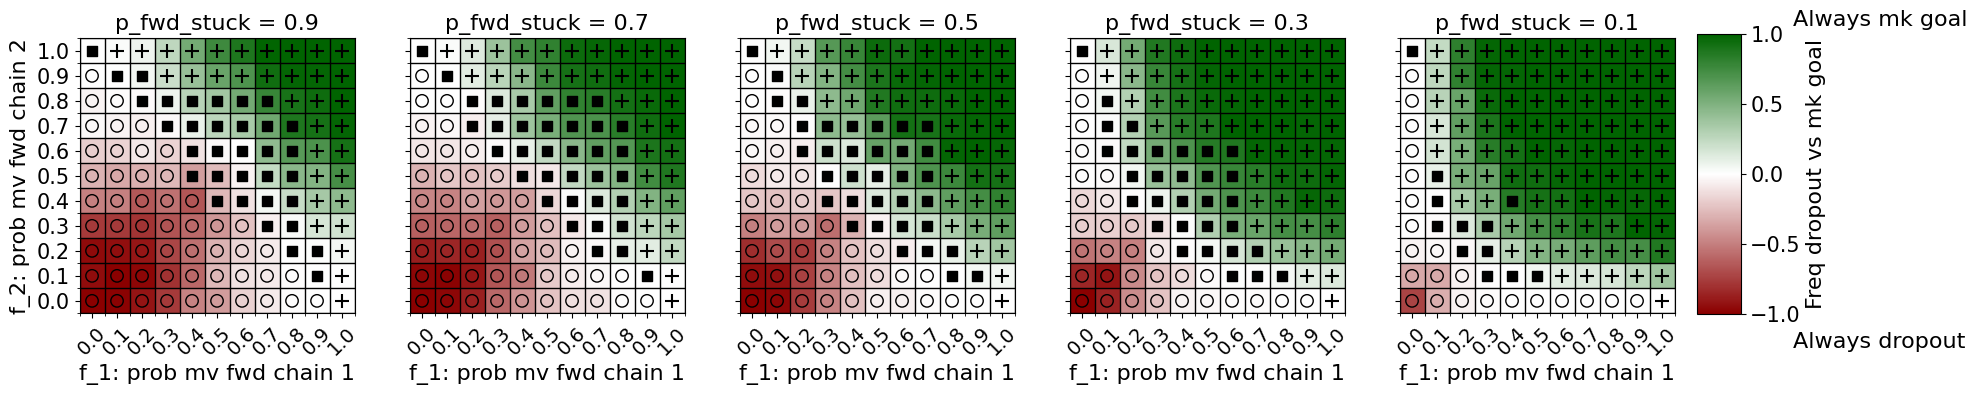

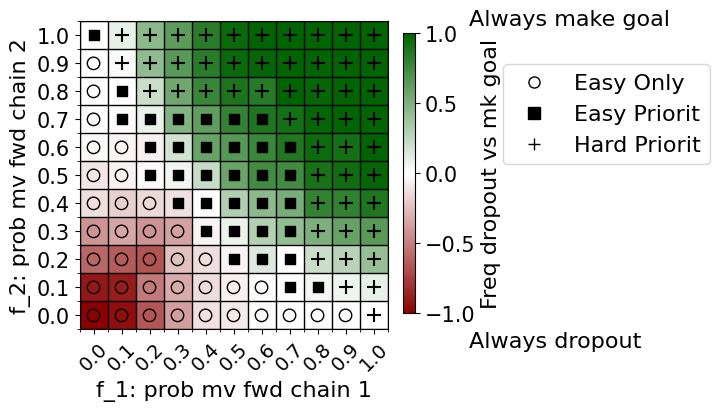

In [46]:
# Reproducing policy class heatmap(s)
unique_other_dec = [0.9, 0.7, 0.5, 0.3, 0.1]
save_path = os.path.join("notebook_figures", "human", "hmap_vary_fd.png")
if not os.path.isdir(os.path.join("notebook_figures", "human")):
    os.makedirs(os.path.join("notebook_figures", "human"))
vis_vary_f1_f2_other_heatmap_1scale_pol(df, "p_fwd_stuck", decreasing=True, save_path=save_path,
                                    num_trajs = 100, unique_other=unique_other_dec)
# Get just one: p_fwd_stuck = 0.4
save_path = os.path.join("notebook_figures", "human", "hmap_fd-0.4.png")
vis_vary_f1_f2_other_heatmap_1scale_pol(df, "p_fwd_stuck", decreasing=True, save_path=save_path,
                                    num_trajs = 100, unique_other=[0.4])

Reproducing number of timesteps to end easier and harder chains for human baseline figures: see Designing AI Interventions for MHBC Settings section.

## Designing AI Interventions for MHBC Settings

Sampling human and human under AI trajectories under human and AI optimal policies, saving data for examining impact of AI intervention on the human agent's ability to reach the goal versus dropout, as well as the end of chains.

In [ ]:
"""
File for creating the AI MDP and policy, as well as human's policy under
the AI's interventions, from human MDP parameters.
Gets behavior results (freq dropout/stay end of 1/mk goal) as well
as first stuck chain state do stuck vs chain 1 intervention at (avg'd across prog
states), for varying p_fwd_stuck, with intervention of p_fwd_stuck dec
by 0.2 under intervention, as well as intervention of p_fwd_chain1 inc
by 0.2 under intervention.

NOTE: does stuck state starting from initial stuck state = 1.  Uses
-1 as a garbage value for when AI never intervenes.

NOTE: this verson allows for just sampling from the human's policy,
the human under the AI's policy, or both!

NOTE: the AI can take the following actions:
0: do nothing
1: reduce probability of moving forward on the stuck chain
2: increase probability of moving forward on chain 1
3: increase probability of moving forward on chain 2

Records the following stats:
- Frequency with which human agent reached the end of the easier chain
- Frequency with which human agent reached the end of the harder chain
- Frequency with which human agent reached the goal state
- Frequency with which human agent dropped out
- Number of actions human agent took until getting to an
absorbing state (one of s_g, s_d, or end of easy forever)
- Number of AI interventions AI agent did until human reached
an absorbing state
"""

def mk_run_progchainworld_w_ai_and_stats(chain_1_dim: int, chain_2_dim: int, stuck_chain_dim: int,
                          p_fwd_chain_1: float, p_fwd_chain_2: float,
                          relapse_chain_1: float, relapse_chain_2: float,
                          p_fwd_stuck: float, p_back_stuck: float,
                          p_fwd_chain1_intervention: float, p_fwd_chain2_intervention: float,
                          p_fwd_stuck_intervention: float,
                          r_goal: float, r_dropout: float, r_intervention: float,
                          num_ai_actions: int,
                          print_none: bool,
                          sample_human_trajectories: bool, sample_AI_trajectories: bool,
                          n_trajs_to_sample: int, max_n_steps_per_rollout: int,
                          df: pd.DataFrame, iteration: int, gamma: float, delta_vi: float,
                          save_folder: str, save_file: str):
    """
    Helper function for instantiating a human multiprogress chainworld
    and AI agent and repeatedly sampling AI-human trajectories from it.  
    Logs metrics and statistics from sampled trajectory to a df.

    Parameters:
    -----------
    chain_1_dim, chain_2_dim, stuck_chain_dim: ints
        length of progress chain 1, progress chain 2, and disengagement chain
    p_fwd_chain_1, p_fwd_chain_2, relapse_chain_1, relapse_chain_2: floats in [0, 1]
        f_1, f_2, b_1, b_2 as defined in paper
    p_fwd_stuck, p_back_stuck: floats in [0, 1]
        f_d, b_d as defined in paper
    p_fwd_chain1_intervention, p_fwd_chain2_intervention, p_fwd_stuck_intervention: floats in [0, 1]
        f_1 + \Delta_{AI}, f_2 + \Delta_{AI}, f_d - \Delta_{AI} (f_1, f_2, and f_d
        under AI intervention on progress chain 1, progress chain 2, and disengagement
        chain, respectively)
    r_goal, r_dropout, r_intervention: floats
        r_g, r_d, r_{inter} as defined in paper: reward for reaching goal state s_g and 
        dropout state s_d, and reward (cost) of AI intervention, respectively
    num_ai_actions: int
        number of possible AI actions (should be 4: do nothing, intervene on disengagement
        chain, intervene on progress chain 1, intervene on progress chain 2)
    print_none: bool
        if True: silences print to speed up running code
    sample_human_trajectories, sample_AI_trajectories: bools
        whether to sample human trajectories without AI intervention and
        whether to sample AI-human trajectories (human under AI intervention)
        if True: samples the trajectories
    n_trajs_to_sample, max_n_steps_per_rollout: ints
        samples n_trajs_to_sample trajectories (if a sample_..._trajectories is True),
        each of length max_n_steps_per_rollout timesteps)
    df, iteration: pd.DataFrame, int
        DataFrame to append data to (should have column names of 'column_names' variable
        in the cell block below, depending on which trajectories are being sampled),
        iteration of sampling trajectories
    gamma, delta_vi: floats
        discount factor and threshold for convergence for value iteration
    save_folder, save_file: strs
        directory and .csv file name to save the logged statistics from sampling
        trajectories to (logged in the inputted df)
    """
    if not print_none:
        print("Probability of moving forward on chain 1 is {}\n".format(p_fwd_chain_1))
        print("Probability of moving forward on chain 2 is {}\n".format(p_fwd_chain_2))
        print("Probability of relapse when don't move forward on chain 1 is {}\n".format(relapse_chain_1))
        print("Probability of relapse when don't move forward on chain 2 is {}\n".format(relapse_chain_2))
        print(f"Probability of moving fwd on stuck chain: {p_fwd_stuck}")
        print(f"Probability of moving back on stuck chain: {p_back_stuck}")
        print(f"Probability of moving fwd on stuck chain under its intervention: {p_fwd_stuck_intervention}")

    # Set up
    prog_chain_dims = [chain_1_dim, chain_2_dim]
    p_fwd_prog_chains = [p_fwd_chain_1, p_fwd_chain_2]
    p_back_prog_chains = [relapse_chain_1, relapse_chain_2]

    p_fwd_prog_chains_intervention_chain1 = [p_fwd_chain1_intervention, p_fwd_chain_2]
    p_fwd_prog_chains_intervention_chain2 = [p_fwd_chain_1, p_fwd_chain2_intervention]


    # Make human transition matrices for baseline and for each intervention
    T_human = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    T_human_intervention_stuck = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck_intervention, p_back_stuck=p_back_stuck)

    T_human_intervention_chain1 = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                 p_fwd_prog_chains=p_fwd_prog_chains_intervention_chain1,
                                 p_back_prog_chains=p_back_prog_chains,
                                 p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    T_human_intervention_chain2 = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                 p_fwd_prog_chains=p_fwd_prog_chains_intervention_chain2,
                                 p_back_prog_chains=p_back_prog_chains,
                                 p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    # Make human reward matrix
    R_human = make_rewards_stuck(chain_1_dim=chain_1_dim, chain_2_dim=chain_2_dim,
                    stuck_chain_dim=stuck_chain_dim, r_goal=r_goal,
                    r_dropout=r_dropout)

    # Solve for optimal human policies
    pi_human, Q_human, V_human = value_iteration(T_human, R_human, gamma, delta=delta_vi)
    pi_human_intervention_stuck, Q_human_intervention_stuck, V_human_intervention_stuck = value_iteration(T_human_intervention_stuck, R_human, gamma, delta=delta_vi)
    pi_human_intervention_chain1, Q_human_intervention_chain1, V_human_intervention_chain1 = value_iteration(T_human_intervention_chain1, R_human, gamma, delta=delta_vi)
    pi_human_intervention_chain2, Q_human_intervention_chain2, V_human_intervention_chain2 = value_iteration(T_human_intervention_chain2, R_human, gamma, delta=delta_vi)

    # Start assembling AI transition matrix and policy
    # have one transition matrix per intervention action AI does (first is no intervention)
    # and optimal human policy learned for that transition matrix
    T_humans = [T_human, T_human_intervention_stuck, T_human_intervention_chain1, T_human_intervention_chain2]
    pi_humans = [pi_human, pi_human_intervention_stuck, pi_human_intervention_chain1, pi_human_intervention_chain2]

    # Create AI agent which can perform all intervention actions
    # create AI transition matrix: uses human transitions corresponding to action AI took
    # can only transition to a state via an action the corresponding human policy states
    T_AI = build_T_ai(T_humans=T_humans, pi_humans=pi_humans, multi_hot_pis=True)

    # create AI reward matrix
    R_AI = build_R_ai(num_ai_actions, R_human, prog_chain_dims, stuck_chain_dim, r_goal, r_dropout, r_intervention)

    # NOTE: AI policy uses states of form (progress chain state, stuck chain state, human action)
    ai_policy, Q, V = value_iteration(T_AI, R_AI, gamma)

    # Num states in human action space = do no work + work on each progress chain i
    A_h = len(prog_chain_dims) + 1
    # AI states consist of tuples of form (s_h, a_h), a_h is human action
    chain_dims = prog_chain_dims + [stuck_chain_dim]
    AI_state_dims = chain_dims + [A_h]

    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    # Set up for sampling
    if sample_human_trajectories or sample_AI_trajectories:
        # keep track of statistics of number of times human agent made goal on its
        # own versus under AI intervention policy
        # NOTE: will figure out which chain is easy vs hard later, this is storage for now
        if sample_human_trajectories:
            n_mk_goal_baseline = 0
            n_dropout_baseline = 0
            n_mk_end_c1_baseline = 0
            n_mk_end_c2_baseline = 0
            n_human_actions_baseline = []
            human_rwds_baseline = []

        if sample_AI_trajectories:
            n_mk_goal_intervention = 0
            n_dropout_intervention = 0
            n_mk_end_c1_intervention = 0
            n_mk_end_c2_intervention = 0
            n_interventions = []
            AI_rwds = [] # each element is the sum of the cumulated AI rewards
            n_human_actions_intervention = []
            human_rwds_intervention = []


        # the below are the number of actions the human agent took
        # before hitting the easy and hard chains for the first time
        # this is for use in seeing successfulness of the diff
        # objectives of the diff strategies (NOTE will figure out
        # which chain is easy vs hard later, this is storage for now)
        if sample_human_trajectories:
            n_ts_to_end_c1_baseline = []
            n_ts_to_end_c2_baseline = []
        if sample_AI_trajectories:
            n_ts_to_end_c1_intervention = []
            n_ts_to_end_c2_intervention = []

        # splitting n ts cases to differentiate goal v dropout
        # will skip entering a value if didn't hit goal/dropout
        # and divide by the number of items in them
        if sample_human_trajectories:
            n_ts_to_goal_baseline = []
            n_ts_to_dropout_baseline = []
        if sample_AI_trajectories:
            n_ts_to_goal_intervention = []
            n_ts_to_dropout_intervention = []


        # Run sampling for AI
        if sample_AI_trajectories:
            # Human under AI intervention policy
            # now sample trajectory:
            # start at (0, 0, 0), no prior action taken (set default one of 0--doesn't matter
            # bc the action from the step b4 doesn't matter when trying to find prob of transition
            # to next state from current state)
            start_state = (0, 0, 0, 0)
            for r in range(n_trajs_to_sample):
                traj_states, traj_actions = sample_trajectory(ai_policy, T_AI, start_state, AI_state_dims, max_n_steps_per_rollout)

                # convert trajectory state indices to tuples (is of form (s_h, a_h))
                traj_states_tuples = [index_to_state(state_idx, AI_state_dims) for state_idx in traj_states]

                # a: prog chain 1 state, b: prog chain 2 state: c: stuck chain state, d: human action at prev state
                hit_goal = any(a == chain_1_dim-1 and b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
                if hit_goal:
                    n_mk_goal_intervention += 1
                    hit_dropout = False
                else:
                    # put in else since can hit goal and dropout simultaneously, but we count
                    # that as hitting the goal
                    hit_dropout = any(c == stuck_chain_dim - 1 for a, b, c, d in traj_states_tuples)
                    if hit_dropout:
                        n_dropout_intervention +=1

                # number of AI intervention actions
                n_interventions.append(np.sum(traj_actions > 0))
                # number of human actions in human trajectory under AI intervention
                n_human_actions_intervention.append(len(traj_actions))
                # AI rwds
                AI_rwds.append(sum([(gamma**i) * R_AI[traj_states[i], traj_actions[i], traj_states[i+1]] for i in range(len(traj_states) - 1)]))

                # human under AI rewards (need to split AI states into the
                # human states and actions)
                human_cumulative_reward = 0
                for i in range(1, len(traj_states)):
                    prog_1_prev_state, prog_2_prev_state, stuck_prev_state, _ = traj_states_tuples[i-1]
                    prog_1_next_state, prog_2_next_state, stuck_next_state, prev_human_action = traj_states_tuples[i-1]
                    prev_state_idx = state_to_index((prog_1_prev_state, prog_2_prev_state, stuck_prev_state), dim_sizes=chain_dims)
                    next_state_idx = state_to_index((prog_1_next_state, prog_2_next_state, stuck_next_state), dim_sizes=chain_dims)
                    human_cumulative_reward += (gamma**(i-1)) * R_human[prev_state_idx, prev_human_action, next_state_idx]
                human_rwds_intervention.append(human_cumulative_reward)

                # check whether mk end progress chain 1
                hit_end_prog_1 = any(a == chain_1_dim-1 for a, b, c, d in traj_states_tuples)
                n_mk_end_c1_intervention += hit_end_prog_1
                # check whether mk end progress chain 2
                hit_end_prog_2 = any(b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
                n_mk_end_c2_intervention += hit_end_prog_2

                # num ts to end c1 (if applicable)
                if hit_end_prog_1:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c1 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1)
                    n_ts_to_end_c1_intervention.append(num_ts_to_end_c1)
                # num ts to end c2 (if applicable)
                if hit_end_prog_2:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c2 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if b == chain_2_dim - 1)
                    n_ts_to_end_c2_intervention.append(num_ts_to_end_c2)
                # num ts to goal (if applicable)
                if hit_goal:
                    num_ts_to_goal = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1 and b == chain_2_dim - 1)
                    n_ts_to_goal_intervention.append(num_ts_to_goal)
                # num ts to dropout (if applicable)
                elif hit_dropout:
                    num_ts_to_dropout = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if c == stuck_chain_dim - 1)
                    n_ts_to_dropout_intervention.append(num_ts_to_dropout)

        # Sampling under human baseline
        if sample_human_trajectories:
            # Human under baseline policy
            start_state = (0, 0, 0)
            for r in range(n_trajs_to_sample):
                traj_states, traj_actions = sample_trajectory(pi_human, T_human, start_state, chain_dims, max_n_steps_per_rollout)

                # convert trajectory state indices to tuples (is of form (s_h, a_h))
                traj_states_tuples = [index_to_state(state_idx, chain_dims) for state_idx in traj_states]

                # a: prog chain 1 state, b: prog chain 2 state: c: stuck chain state
                hit_goal = any(a == chain_1_dim-1 and b == chain_2_dim-1 for a, b, c in traj_states_tuples)
                if hit_goal:
                    n_mk_goal_baseline += 1
                    hit_dropout = False
                else:
                    hit_dropout = any(c == stuck_chain_dim - 1 for a, b, c in traj_states_tuples)
                    if hit_dropout:
                        n_dropout_baseline += 1

                # number of human actions in human trajectory
                n_human_actions_baseline.append(len(traj_actions))

                # human baseline cumulative rewards
                human_rwds_baseline.append(sum([(gamma**i) * R_human[traj_states[i], traj_actions[i], traj_states[i+1]] for i in range(len(traj_states) - 1)]))

                # check whether mk end progress chain 1
                hit_end_prog_1 = any(a == chain_1_dim-1 for a, b, c in traj_states_tuples)
                n_mk_end_c1_baseline += hit_end_prog_1
                # check whether mk end progress chain 2
                hit_end_prog_2 = any(b == chain_2_dim-1 for a, b, c in traj_states_tuples)
                n_mk_end_c2_baseline += hit_end_prog_2

                # num timesteps to end chain 1 (if applicable)
                if hit_end_prog_1:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c1 = 1 + next(i for i, (a, b, c) in enumerate(traj_states_tuples) if a == chain_1_dim - 1)
                    n_ts_to_end_c1_baseline.append(num_ts_to_end_c1)
                # num ts to end c2 (if applicable)
                if hit_end_prog_2:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c2 = 1 + next(i for i, (a, b, c) in enumerate(traj_states_tuples) if b == chain_2_dim - 1)
                    n_ts_to_end_c2_baseline.append(num_ts_to_end_c2)
                # num ts to goal (if applicable)
                if hit_goal:
                    num_ts_to_goal = 1 + next(i for i, (a, b, c) in enumerate(traj_states_tuples) if a == chain_1_dim - 1 and b == chain_2_dim - 1)
                    n_ts_to_goal_baseline.append(num_ts_to_goal)
                # num ts to dropout (if applicable)
                if hit_dropout:
                    num_ts_to_dropout = 1 + next(i for i, (a, b, c) in enumerate(traj_states_tuples) if c == stuck_chain_dim - 1)
                    n_ts_to_dropout_baseline.append(num_ts_to_dropout)


        # calculate frequency of making goal and dropping out under human baseline
        # versus human under AI intervention, as well as reaching chain ends
        if sample_AI_trajectories: # stats for human under intervention
            freq_goal_intervention = n_mk_goal_intervention / n_trajs_to_sample
            freq_dropout_intervention = n_dropout_intervention / n_trajs_to_sample
            freq_end_c1_intervention = n_mk_end_c1_intervention / n_trajs_to_sample # freq reach end chain 1
            freq_end_c2_intervention = n_mk_end_c2_intervention / n_trajs_to_sample # freq reach end chain 2

        if sample_human_trajectories: # stats for human baseline
            freq_goal_baseline = n_mk_goal_baseline / n_trajs_to_sample
            freq_dropout_baseline = n_dropout_baseline / n_trajs_to_sample
            freq_end_c1_baseline = n_mk_end_c1_baseline / n_trajs_to_sample
            freq_end_c2_baseline = n_mk_end_c2_baseline / n_trajs_to_sample

        # Easier chain to get to end of is one with higher p_fwd) bc set
        # up both to have same p_back), determine which that is
        if p_fwd_chain_1 >= p_fwd_chain_2:
            # chain 1 is easier chain to work on
            if sample_AI_trajectories:
                freq_end_easier_inter = freq_end_c1_intervention
                freq_end_harder_inter = freq_end_c2_intervention
                n_ts_to_end_easier_inter = n_ts_to_end_c1_intervention
                n_ts_to_end_harder_inter = n_ts_to_end_c2_intervention
            if sample_human_trajectories:
                freq_end_easier_baseline = freq_end_c1_baseline
                freq_end_harder_baseline = freq_end_c2_baseline
                n_ts_to_end_easier_baseline = n_ts_to_end_c1_baseline
                n_ts_to_end_harder_baseline = n_ts_to_end_c2_baseline

        else:
            # chain 2 is easier chain to work on
            if sample_AI_trajectories:
                freq_end_easier_inter = freq_end_c2_intervention
                freq_end_harder_inter = freq_end_c1_intervention
                n_ts_to_end_easier_inter = n_ts_to_end_c2_intervention
                n_ts_to_end_harder_inter = n_ts_to_end_c1_intervention

            if sample_human_trajectories:
                freq_end_easier_baseline = freq_end_c2_baseline
                freq_end_harder_baseline = freq_end_c1_baseline
                n_ts_to_end_easier_baseline = n_ts_to_end_c2_baseline
                n_ts_to_end_harder_baseline = n_ts_to_end_c1_baseline

        # Process additional stats for potential boxplots
        if sample_human_trajectories:
            human_stats_list_vars = [n_human_actions_baseline,
                         human_rwds_baseline, n_ts_to_goal_baseline,
                         n_ts_to_dropout_baseline, n_ts_to_end_easier_baseline,
                         n_ts_to_end_harder_baseline]

            human_stats_lists = []
            for i in range(len(human_stats_list_vars)):
                var_list = human_stats_list_vars[i]
                if len(var_list) > 0:
                    avg_value = np.mean(var_list)
                    std_value = np.std(var_list)
                    min_value = np.min(var_list)
                    quartile_one, median, quartile_three = np.percentile(var_list, [25, 50, 75])
                    max_value = np.max(var_list)
                    var_stats_list = [avg_value, std_value, min_value, quartile_one, median, quartile_three, max_value]
                else:
                    var_stats_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
                human_stats_lists.append(var_stats_list)

        if sample_AI_trajectories:
            AI_stats_list_vars = [n_interventions, AI_rwds, n_human_actions_intervention,
                         human_rwds_intervention, n_ts_to_goal_intervention,
                         n_ts_to_dropout_intervention, n_ts_to_end_easier_inter,
                         n_ts_to_end_harder_inter]

            AI_stats_lists = []
            for i in range(len(AI_stats_list_vars)):
                var_list = AI_stats_list_vars[i]
                if len(var_list) > 0:
                    avg_value = np.mean(var_list)
                    std_value = np.std(var_list)
                    min_value = np.min(var_list)
                    quartile_one, median, quartile_three = np.percentile(var_list, [25, 50, 75])
                    max_value = np.max(var_list)
                    var_stats_list = [avg_value, std_value, min_value, quartile_one, median, quartile_three, max_value]
                else:
                    var_stats_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
                AI_stats_lists.append(var_stats_list)

        # Create rows of dataframe
        if sample_AI_trajectories and not sample_human_trajectories:
            new_row = [chain_1_dim, chain_2_dim,
                    p_fwd_chain_1, p_fwd_chain1_intervention,
                    p_fwd_chain_2, p_fwd_chain2_intervention,
                    relapse_chain_1, relapse_chain_2,
                    p_fwd_stuck, p_fwd_stuck_intervention, p_back_stuck,
                    freq_goal_intervention, freq_dropout_intervention,
                    freq_end_easier_inter, freq_end_harder_inter
                    ]

            for var_stats_list in AI_stats_lists:
                new_row = new_row + var_stats_list

        elif sample_AI_trajectories and sample_human_trajectories:
            new_row = [chain_1_dim, chain_2_dim,
            p_fwd_chain_1, p_fwd_chain1_intervention,
            p_fwd_chain_2, p_fwd_chain2_intervention,
            relapse_chain_1, relapse_chain_2,
            p_fwd_stuck, p_fwd_stuck_intervention, p_back_stuck,
            freq_goal_baseline, freq_dropout_baseline,
            freq_goal_intervention, freq_dropout_intervention,
            freq_end_easier_baseline, freq_end_harder_baseline,
            freq_end_easier_inter, freq_end_harder_inter
            ]
            for var_stats_list in human_stats_lists:
                new_row = new_row + var_stats_list
            for var_stats_list in AI_stats_lists:
                new_row = new_row + var_stats_list
        else: # sampled human only
            new_row = [chain_1_dim, chain_2_dim,
            p_fwd_chain_1, p_fwd_chain_2,
            relapse_chain_1, relapse_chain_2,
            p_fwd_stuck, p_back_stuck,
            freq_goal_baseline, freq_dropout_baseline,
            freq_end_easier_baseline, freq_end_harder_baseline
            ]
            for var_stats_list in human_stats_lists:
                new_row = new_row + var_stats_list


        # replace row at current iteration
        df.iloc[iteration] = new_row
        # save dataframe every 20k iters
        if iteration % 20000 == 0:
            df.to_csv(os.path.join(save_folder, save_file + "_w_inter.csv"))




In [ ]:
# Set up to run function above for a set of human MDPs
# Folder to save to
save_folder = os.path.join("notebook_results", "ai")
save_file = "human_ai_stats_policy_classes"

# rewards for human and AI agents
r_goal = 10 # Reward for reaching end of both progress chains
r_dropout = -10
# rewards for AI agent
r_intervention = -0.1

print_none = True # if True, prints things
sample_human_trajectories = True # sample just human baseline trajectories
sample_AI_trajectories = True # sample human under AI trajectories (intervention on stuck + chain 1)

# Progchain world parameters
chain_1_dim = 5
chain_2_dim = 5
stuck_chain_dim = 5

chain_1_goal = chain_1_dim - 1
chain_2_goal = chain_2_dim - 1
end_stuck = stuck_chain_dim - 1

gamma = 0.9 # discount factor for value iteration (VI)
delta_vi = 1e-4 # threshold of change in V to stop VI
num_ai_actions = 4 # see list of actions in file header

n_trajs_to_sample = 200
max_n_steps_per_rollout = 80

# Create set of human MDPs (by policy class cases)
configs = [
    {"label": "Easy-Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Easy-Only-Border-Priorit",  "p_fwd_chain_1": 0.2,  "p_fwd_chain_2": 0.4, "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior-Border-Hard", "p_fwd_chain_1": 0.4, "p_fwd_chain_2": 0.5,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior-Border-Hard-Closer", "p_fwd_chain_1": 0.5, "p_fwd_chain_2": 0.7,  "p_fwd_stuck": 0.4},
    {"label": "Hard-Prior", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4}
]

p_back_chain_1 = 0.3
p_back_chain_2 = 0.3
p_back_stuck = 0.5

# Pre-instantiate dataframe
col_names_stuck_inter_counts = [f"stuck_inter_at_stuck-{i}" for i in range(stuck_chain_dim)]
col_names_f1_inter_counts = [f"f1_inter_at_stuck-{i}" for i in range(stuck_chain_dim)]

human_stats_list_varnames = ["n_human_actions_baseline",
                        "human_rwds_baseline", "n_ts_to_goal_baseline",
                        "n_ts_to_dropout_baseline", "n_ts_to_end_easier_baseline",
                         "n_ts_to_end_harder_baseline"]
AI_stats_list_varnames = ["n_interventions", "AI_rwds", "n_human_actions_inter",
                        "human_rwds_inter", "n_ts_to_goal_inter",
                        "n_ts_to_dropout_inter", "n_ts_to_end_easier_inter",
                         "n_ts_to_end_harder_inter"]

if sample_AI_trajectories and sample_human_trajectories:
    column_names = ['chain_1_dim', 'chain_2_dim',
                    'p_fwd_chain_1', 'p_fwd_chain_1_inter',
                    'p_fwd_chain_2', 'p_fwd_chain_2_inter',
                    'relapse_chain_1', 'relapse_chain_2',
                    'p_fwd_stuck', 'p_fwd_stuck_inter', 'p_back_stuck',
                    'freq_mk_goal_baseline', 'freq_dropout_baseline',
                    'freq_mk_goal_inter', 'freq_dropout_inter',
                    'freq_end_easier_baseline', 'freq_end_harder_baseline', # frequency of making it to end of easier/harder chain
                    'freq_end_easier_inter', 'freq_end_harder_inter'
                    ]
    for stat_varname in human_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname
    for stat_varname in AI_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname

elif sample_AI_trajectories:
    # only sampling AI trajectories
    column_names = ['chain_1_dim', 'chain_2_dim',
                            'p_fwd_chain_1', 'p_fwd_chain_1_inter',
                            'p_fwd_chain_2', 'p_fwd_chain_2_inter',
                            'p_back_chain_1', 'p_back_chain_2',
                            'p_fwd_stuck', 'p_fwd_stuck_inter', 'p_back_stuck',
                            'freq_mk_goal_inter', 'freq_dropout_inter',
                            'freq_end_easier_inter', 'freq_end_harder_inter'
                            ]
    for stat_varname in AI_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname

elif sample_human_trajectories:
    column_names = ['chain_1_dim', 'chain_2_dim',
                    'p_fwd_chain_1', 'p_fwd_chain_2',
                    'relapse_chain_1', 'relapse_chain_2',
                    'p_fwd_stuck', 'p_back_stuck',
                    'freq_mk_goal_baseline', 'freq_dropout_baseline',
                    'freq_end_easier_baseline', 'freq_end_harder_baseline'
                    ]
    for stat_varname in human_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname

iteration = 0  # starting over in new df

df = pd.DataFrame(np.zeros((len(configs), len(column_names))), columns=column_names)


# Sample AI/human trajectories for each human MDP parameter setting
for config in configs:
    p_fwd_chain_1 = config["p_fwd_chain_1"]
    p_fwd_chain_2 = config["p_fwd_chain_2"]
    p_fwd_stuck = config["p_fwd_stuck"]
    df_label = config["label"]
    print(f"config label: {df_label}")

    # did delta 0.2 so can match up to human baseline (bc skipped by 0.2 for p_fwd_stuck
    # in results where vary that one)
    p_fwd_stuck_intervention = max(0, p_fwd_stuck - 0.2)
    # did delta 0.2 to match w stuck intervention
    p_fwd_chain1_intervention = min(1, p_fwd_chain_1 + 0.2)
    p_fwd_chain2_intervention = min(1, p_fwd_chain_2 + 0.2)

    mk_run_progchainworld_w_ai_and_stats(chain_1_dim, chain_2_dim, stuck_chain_dim,
                          p_fwd_chain_1, p_fwd_chain_2,
                          p_back_chain_1, p_back_chain_2,
                          p_fwd_stuck, p_back_stuck,
                          p_fwd_chain1_intervention, p_fwd_chain2_intervention,
                          p_fwd_stuck_intervention,
                          r_goal, r_dropout, r_intervention,
                          num_ai_actions,
                          print_none,
                          sample_human_trajectories, sample_AI_trajectories,
                          n_trajs_to_sample, max_n_steps_per_rollout,
                          df, iteration, gamma, delta_vi,
                          save_folder, save_file)

    iteration += 1

df.to_csv(os.path.join(save_folder, save_file + "_w_inter.csv"))

config label: Easy-Only
config label: Easy-Only-Border-Priorit
config label: Easy-Prior
config label: Easy-Prior-Border-Hard
config label: Easy-Prior-Border-Hard-Closer
config label: Hard-Prior


Reproducing number of timesteps to end easier and harder chains for human baseline figures (for "Modeling Human Decision-Making in MHBC Settings" section above)

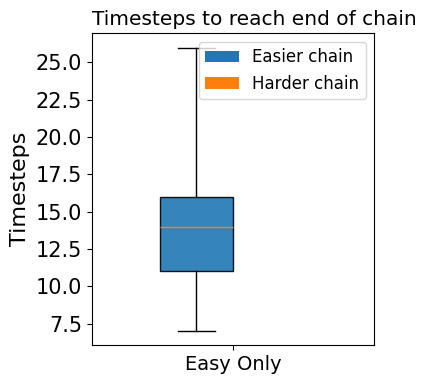

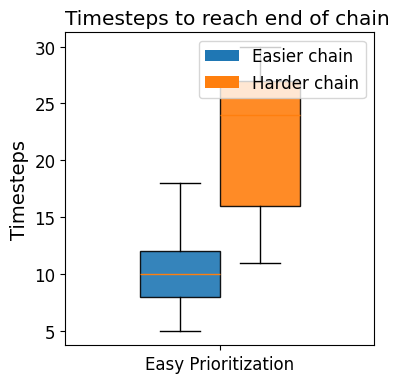

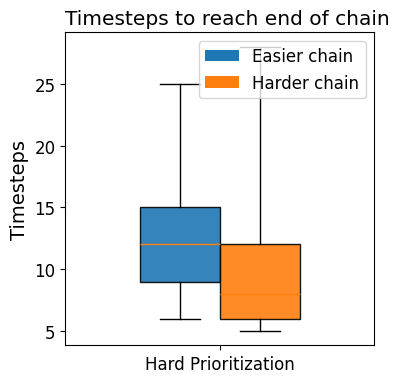

In [49]:
# Create the boxplot of n ts to end of easier and harder chain for each human
# agent policy class
save_folder = os.path.join("notebook_results", "ai")
save_file = "human_ai_stats_policy_classes"
df = pd.read_csv(os.path.join(save_folder, save_file + "_w_inter.csv"))

main_configs = [
    {"label": "Easy Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Easy Prioritization", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Hard Prioritization", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4}
]

easy_only_config = [main_configs[0]]
easy_prior_config = [main_configs[1]]
hard_prior_config = [main_configs[2]]

save_dir = "notebook_figures/human"
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

figsize = (4, 4)

file_name = "easy-only_n_ts_end_easier_vs_harder.png"
human_easier_vs_harder_n_ts_end_boxplots(df, easy_only_config, save=True, save_dir=save_dir, filename=file_name, figsize=figsize)

file_name = "easy-prior_n_ts_end_easier_vs_harder.png"
human_easier_vs_harder_n_ts_end_boxplots(df, easy_prior_config, save=True, save_dir=save_dir, filename=file_name, figsize=figsize)

file_name = "hard-prior_n_ts_end_easier_vs_harder.png"
human_easier_vs_harder_n_ts_end_boxplots(df, hard_prior_config, save=True, save_dir=save_dir, filename=file_name, figsize=figsize)

Reproducing policy classes under AI interventions stats: frequency of outcomes, as well as number of timesteps to end of easier vs harder progress chains, with and without AI intervention.

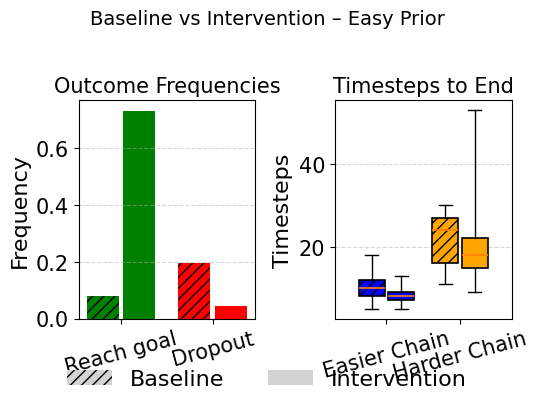

Saved plot to notebook_figures/ai/easy-prior-baseline-v-ai.png


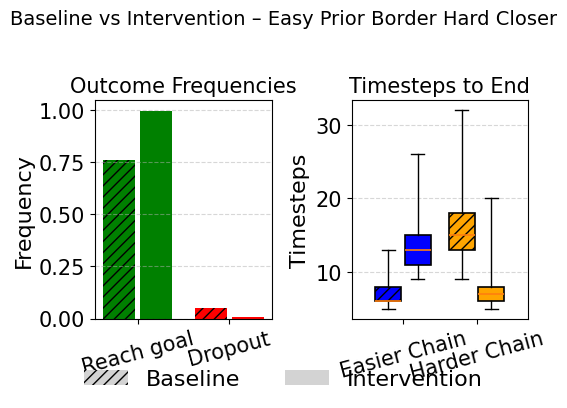

Saved plot to notebook_figures/ai/easy-prior-border-hard-closer-baseline-v-ai.png


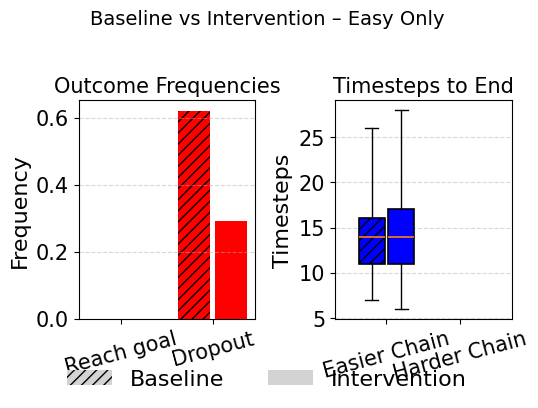

Saved plot to notebook_figures/ai/easy-only-baseline-v-ai.png


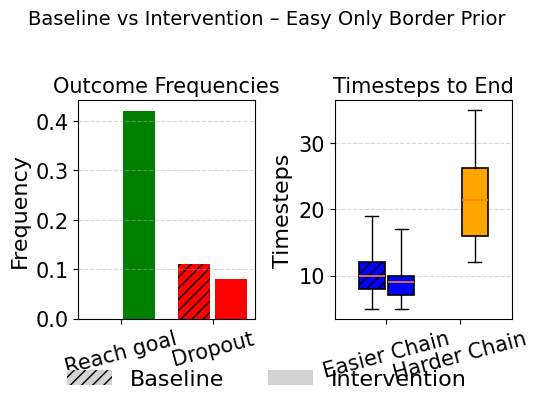

Saved plot to notebook_figures/ai/easy-only-border-prior-baseline-v-ai.png


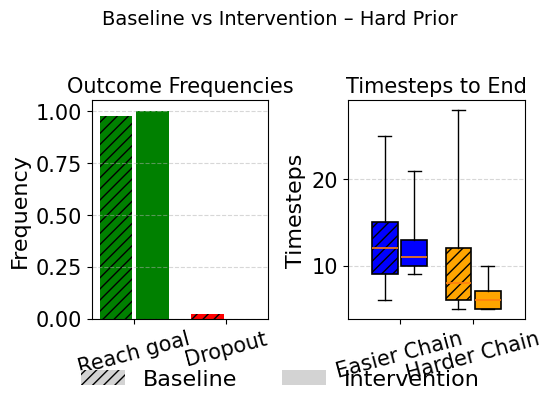

Saved plot to notebook_figures/ai/hard-prior-baseline-v-ai.png


In [50]:
# Making visualization for freq mk goal vs dropout a n ts end easy vs hard
# under baseline vs under intervention
save_folder = os.path.join("notebook_results", "ai")
save_file = "human_ai_stats_policy_classes"
df = pd.read_csv(os.path.join(save_folder, save_file + "_w_inter.csv"))

configs = [
    {"label": "Easy Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Easy Only Border Prior",  "p_fwd_chain_1": 0.2,  "p_fwd_chain_2": 0.4, "p_fwd_stuck": 0.4},
    {"label": "Easy Prior", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Easy Prior Border Hard", "p_fwd_chain_1": 0.4, "p_fwd_chain_2": 0.5,  "p_fwd_stuck": 0.4},
    {"label": "Easy Prior Border Hard Closer", "p_fwd_chain_1": 0.5, "p_fwd_chain_2": 0.7,  "p_fwd_stuck": 0.4},
    {"label": "Hard Prior", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4}
]
figsize = (5.5, 4)

config = [configs[2]]

if not os.path.isdir(os.path.join("notebook_figures", "ai")):
    os.makedirs(os.path.join("notebook_figures", "ai"))

save_path = os.path.join("notebook_figures", "ai", "easy-prior-baseline-v-ai.png")
plot_freq_n_timesteps_compar_from_config(df, config, save_path=save_path, figsize=figsize, use_suptitle=True)

config = [configs[4]]
save_path = os.path.join("notebook_figures", "ai", "easy-prior-border-hard-closer-baseline-v-ai.png")
plot_freq_n_timesteps_compar_from_config(df, config, save_path=save_path, figsize=figsize, use_suptitle=True)

# For Appendix:
config = [configs[0]]
save_path = os.path.join("notebook_figures", "ai", "easy-only-baseline-v-ai.png")
plot_freq_n_timesteps_compar_from_config(df, config, save_path=save_path, figsize=figsize, use_suptitle=True)

config = [configs[1]]
save_path = os.path.join("notebook_figures", "ai", "easy-only-border-prior-baseline-v-ai.png")
plot_freq_n_timesteps_compar_from_config(df, config, save_path=save_path, figsize=figsize, use_suptitle=True)

config = [configs[5]]
save_path = os.path.join("notebook_figures", "ai", "hard-prior-baseline-v-ai.png")
plot_freq_n_timesteps_compar_from_config(df, config, save_path=save_path, figsize=figsize, use_suptitle=True)

Reproducing number of AI interventions by policy class

[saved] /content/notebook_figures/ai/boxplot_n_interventions.png
[saved] /content/notebook_figures/ai/boxplot_AI_rwds.png


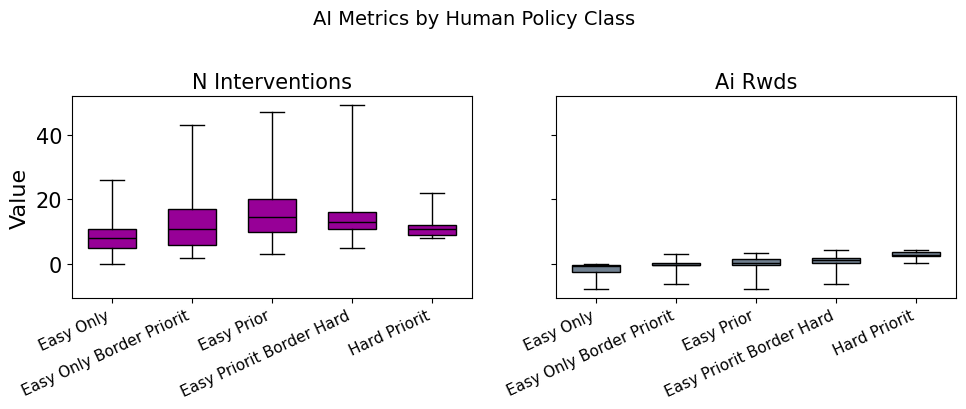

In [51]:
# Reproducing AI interventions by policy class

configs = [
    {"label": "Easy Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Easy Only Border Priorit",  "p_fwd_chain_1": 0.2,  "p_fwd_chain_2": 0.4, "p_fwd_stuck": 0.4},
    {"label": "Easy Prior", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Easy Priorit Border Hard", "p_fwd_chain_1": 0.4, "p_fwd_chain_2": 0.5,  "p_fwd_stuck": 0.4},
    {"label": "Hard Priorit", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4}
]

save_dir = os.path.join("notebook_figures", "ai")


save_folder = os.path.join("notebook_results", "ai")
save_file = "human_ai_stats_policy_classes"
df = pd.read_csv(os.path.join(save_folder, save_file + "_w_inter.csv"))

AI_only_metric_boxplots_solid_colors(
    df,
    configs,
    metrics=("n_interventions", "AI_rwds"),
    shared_yaxis=True,
    save_combined=False,
    save_individual=True,
    save_dir=save_dir,
    dpi=300
)

## AI Robustness under Disengagement Estimation

Sampling AI trajectories under disengagement estimation, as well as saving data for examining impact of disengagement estimation on AI's ability to help the human agent.

In [ ]:
"""
Code for creating the AI MDP and policy from human MDP parameters.  **Will
also sample trajectories under the AI policy utilizing two choices
of stuck estimator (the iterative or sequential stuck estimator)**, logging
statistics about the results.

NOTE: the AI can take the following actions:
0: do nothing
1: reduce probability of moving forward on the stuck chain
2: increase probability of moving forward on chain 1
3: increase probability of moving forward on chain 2

NOTE: this version will make an AI agent that can do all three
actions.  Records the following stats under the stuck estimators:
- Frequency with which human agent reached the end of the easier chain
- Frequency with which human agent reached the end of the harder chain
- Frequency with which human agent reached the goal state
- Frequency with which human agent dropped out
- Number of actions human agent took until getting to an
absorbing state (one of s_g, s_d, or end of easy forever)
- Number of AI interventions AI agent did until human reached
an absorbing state
"""

def mk_run_progchainworld_w_stuck_est(chain_1_dim: int, chain_2_dim: int, stuck_chain_dim: int,
                          p_fwd_chain_1: float, p_fwd_chain_2: float,
                          relapse_chain_1: float, relapse_chain_2: float,
                          p_fwd_stuck: float, p_back_stuck: float,
                          p_fwd_chain1_intervention: float, p_fwd_chain2_intervention: float,
                          p_fwd_stuck_intervention: float,
                          r_goal: float, r_dropout: float, r_intervention: float,
                          num_ai_actions: int,
                          print_none: bool,
                          sample_iter_est_trajectories: bool, sample_seq_est_trajectories: bool,
                          n_trajs_to_sample: int, max_n_steps_per_rollout: int,
                          df: pd.DataFrame, iteration: int, gamma: float, delta_vi: float,
                          save_folder: str, save_file: str):
    """
    Helper function for instantiating a human multiprogress chainworld
    and AI agent and repeatedly sampling AI-human trajectories from it
    under estimation of the human's disenagement state.
    Logs metrics and statistics from sampled trajectory to a df.

    Parameters:
    -----------
    chain_1_dim, chain_2_dim, stuck_chain_dim: ints
        length of progress chain 1, progress chain 2, and disengagement chain
    p_fwd_chain_1, p_fwd_chain_2, relapse_chain_1, relapse_chain_2: floats in [0, 1]
        f_1, f_2, b_1, b_2 as defined in paper
    p_fwd_stuck, p_back_stuck: floats in [0, 1]
        f_d, b_d as defined in paper
    p_fwd_chain1_intervention, p_fwd_chain2_intervention, p_fwd_stuck_intervention: floats in [0, 1]
        f_1 + \Delta_{AI}, f_2 + \Delta_{AI}, f_d - \Delta_{AI} (f_1, f_2, and f_d
        under AI intervention on progress chain 1, progress chain 2, and disengagement
        chain, respectively)
    r_goal, r_dropout, r_intervention: floats
        r_g, r_d, r_{inter} as defined in paper: reward for reaching goal state s_g and 
        dropout state s_d, and reward (cost) of AI intervention, respectively
    num_ai_actions: int
        number of possible AI actions (should be 4: do nothing, intervene on disengagement
        chain, intervene on progress chain 1, intervene on progress chain 2)
    print_none: bool
        if True: silences print to speed up running code
    sample_iter_est_trajectories, sample_seq_est_trajectories: bools
        whether to sample AI-human trajectories under the iterative estimator and
        whether to sample AI-human trajectories under the sequential estimator
        if True: samples the trajectories
    n_trajs_to_sample, max_n_steps_per_rollout: ints
        samples n_trajs_to_sample trajectories (if a sample_..._trajectories is True),
        each of length max_n_steps_per_rollout timesteps)
    df, iteration: pd.DataFrame, int
        DataFrame to append data to (should have column names of 'column_names' variable
        in the cell block below, depending on which trajectories are being sampled),
        iteration of sampling trajectories
    gamma, delta_vi: floats
        discount factor and threshold for convergence for value iteration
    save_folder, save_file: strs
        directory and .csv file name to save the logged statistics from sampling
        trajectories to (logged in the inputted df)
    """
    # Set these to false to save time
    if not print_none:
        print("Probability of moving forward on chain 1 is {}\n".format(p_fwd_chain_1))
        print("Probability of moving forward on chain 2 is {}\n".format(p_fwd_chain_2))
        print("Probability of relapse when don't move forward on chain 1 is {}\n".format(relapse_chain_1))
        print("Probability of relapse when don't move forward on chain 2 is {}\n".format(relapse_chain_2))
        print(f"Probability of moving fwd on stuck chain: {p_fwd_stuck}")
        print(f"Probability of moving back on stuck chain: {p_back_stuck}")
        print(f"Probability of moving fwd on stuck chain under its intervention: {p_fwd_stuck_intervention}")

    # Set up parameters
    prog_chain_dims = [chain_1_dim, chain_2_dim]
    p_fwd_prog_chains = [p_fwd_chain_1, p_fwd_chain_2]
    p_back_prog_chains = [relapse_chain_1, relapse_chain_2]

    p_fwd_prog_chains_intervention_chain1 = [p_fwd_chain1_intervention, p_fwd_chain_2]
    p_fwd_prog_chains_intervention_chain2 = [p_fwd_chain_1, p_fwd_chain2_intervention]


    # Create human transition matrices (for baseline and interventions)
    T_human = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    T_human_intervention_stuck = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck_intervention, p_back_stuck=p_back_stuck)

    T_human_intervention_chain1 = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                 p_fwd_prog_chains=p_fwd_prog_chains_intervention_chain1,
                                 p_back_prog_chains=p_back_prog_chains,
                                 p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    T_human_intervention_chain2 = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                 p_fwd_prog_chains=p_fwd_prog_chains_intervention_chain2,
                                 p_back_prog_chains=p_back_prog_chains,
                                 p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)
    # Make human reward matrix
    R_human = make_rewards_stuck(chain_1_dim=chain_1_dim, chain_2_dim=chain_2_dim,
                    stuck_chain_dim=stuck_chain_dim, r_goal=r_goal,
                    r_dropout=r_dropout)

    # Solve for optimal human policies
    pi_human, Q_human, V_human = value_iteration(T_human, R_human, gamma, delta=delta_vi)
    pi_human_intervention_stuck, Q_human_intervention_stuck, V_human_intervention_stuck = value_iteration(T_human_intervention_stuck, R_human, gamma, delta=delta_vi)
    pi_human_intervention_chain1, Q_human_intervention_chain1, V_human_intervention_chain1 = value_iteration(T_human_intervention_chain1, R_human, gamma, delta=delta_vi)
    pi_human_intervention_chain2, Q_human_intervention_chain2, V_human_intervention_chain2 = value_iteration(T_human_intervention_chain2, R_human, gamma, delta=delta_vi)

    # Start building AI transition matrix and policy
    # have one transition matrix per intervention action AI does (first is no intervention)
    # and optimal human policy learned for that transition matrix
    T_humans = [T_human, T_human_intervention_stuck, T_human_intervention_chain1, T_human_intervention_chain2]
    pi_humans = [pi_human, pi_human_intervention_stuck, pi_human_intervention_chain1, pi_human_intervention_chain2]

    # Create AI agent which can perform all intervention actions
    # create AI transition matrix: uses human transitions corresponding to action AI took
    # can only transition to a state via an action the corresponding human policy states
    T_AI = build_T_ai(T_humans=T_humans, pi_humans=pi_humans, multi_hot_pis=True)

    # create AI reward matrix
    R_AI = build_R_ai(num_ai_actions, R_human, prog_chain_dims, stuck_chain_dim, r_goal, r_dropout, r_intervention)

    # NOTE: AI policy uses states of form (progress chain state, stuck chain state, human action)
    ai_policy, Q, V = value_iteration(T_AI, R_AI, gamma)

    # Num states in human action space = do no work + work on each progress chain i
    A_h = len(prog_chain_dims) + 1
    # AI states consist of tuples of form (s_h, a_h), a_h is human action
    chain_dims = prog_chain_dims + [stuck_chain_dim]
    AI_state_dims = chain_dims + [A_h]

    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    # Set up sampling with disengagement estimation
    if sample_iter_est_trajectories or sample_seq_est_trajectories:
        # keep track of statistics of number of times human agent made goal,
        # dropped out, reached end of either chain, etc under the two stuck
        # chain interventions
        # NOTE: will figure out which chain is easy vs hard later, this is storage for now
        if sample_iter_est_trajectories:
            n_mk_goal_iter = 0
            n_dropout_iter = 0
            n_mk_end_c1_iter = 0
            n_mk_end_c2_iter = 0
            n_interventions_iter = []
            AI_rwds_iter = [] # each element is the sum of the cumulated AI rewards
            n_human_actions_intervention_iter = []
            human_rwds_intervention_iter = []

        if sample_seq_est_trajectories:
            n_mk_goal_seq = 0
            n_dropout_seq = 0
            n_mk_end_c1_seq = 0
            n_mk_end_c2_seq = 0
            n_interventions_seq = []
            AI_rwds_seq = [] # each element is the sum of the cumulated AI rewards
            n_human_actions_intervention_seq = []
            human_rwds_intervention_seq = []

        # the below are the number of actions the human agent took
        # before hitting the easy and hard chains for the first time
        # this is for use in seeing successfulness of the diff
        # objectives of the diff strategies (NOTE will figure out
        # which chain is easy vs hard later, this is storage for now)
        if sample_iter_est_trajectories:
            n_ts_to_end_c1_iter = []
            n_ts_to_end_c2_iter = []
        if sample_seq_est_trajectories:
            n_ts_to_end_c1_seq = []
            n_ts_to_end_c2_seq = []

        # splitting n ts cases to differentiate goal v dropout
        # will skip entering a value if didn't hit goal/dropout
        # and divide by the number of items in them
        if sample_iter_est_trajectories:
            n_ts_to_goal_iter = []
            n_ts_to_dropout_iter= []
        if sample_seq_est_trajectories:
            n_ts_to_goal_seq = []
            n_ts_to_dropout_seq = []


        # Sample using iterative estimator
        if sample_iter_est_trajectories:
            # Human under AI intervention policy using iterative estimator for stuck state
            # now sample trajectory:
            # start at (0, 0, 0), no prior action taken (set default one of 0--doesn't matter
            # bc the action from the step b4 doesn't matter when trying to find prob of transition
            # to next state from current state)
            start_state = (0, 0, 0, 0)

            iter_num_overestimates = 0
            iter_num_underestimates = 0
            iter_total_amt_overestimate = 0
            iter_total_amt_underestimate = 0

            for r in range(n_trajs_to_sample):
                traj_states, traj_actions, num_overestimates_iter, num_underestimates_iter, total_amt_overestimate_iter, total_amt_underestimate_iter = sample_trajectory_under_iter_est(ai_policy, T_AI, start_state, AI_state_dims, max_n_steps_per_rollout)

                # convert trajectory state indices to tuples (is of form (s_h, a_h))
                traj_states_tuples = [index_to_state(state_idx, AI_state_dims) for state_idx in traj_states]

                # a: prog chain 1 state, b: prog chain 2 state: c: stuck chain state, d: human action at prev state
                hit_goal = any(a == chain_1_dim-1 and b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
                if hit_goal:
                    n_mk_goal_iter += 1
                    hit_dropout = False
                else:
                    # put in else since can hit goal and dropout simultaneously, but we count
                    # that as hitting the goal
                    hit_dropout = any(c == stuck_chain_dim - 1 for a, b, c, d in traj_states_tuples)
                    if hit_dropout:
                        n_dropout_iter +=1

                # number of AI intervention actions
                n_interventions_iter.append(np.sum(traj_actions > 0))
                # number of human actions in human trajectory under AI intervention
                n_human_actions_intervention_iter.append(len(traj_actions))
                # AI rwds
                AI_rwds_iter.append(sum([(gamma**i) * R_AI[traj_states[i], traj_actions[i], traj_states[i+1]] for i in range(len(traj_states) - 1)]))

                # human under AI rewards (need to split AI states into the
                # human states and actions)
                human_cumulative_reward = 0
                for i in range(1, len(traj_states)):
                    prog_1_prev_state, prog_2_prev_state, stuck_prev_state, _ = traj_states_tuples[i-1]
                    prog_1_next_state, prog_2_next_state, stuck_next_state, prev_human_action = traj_states_tuples[i-1]
                    prev_state_idx = state_to_index((prog_1_prev_state, prog_2_prev_state, stuck_prev_state), dim_sizes=chain_dims)
                    next_state_idx = state_to_index((prog_1_next_state, prog_2_next_state, stuck_next_state), dim_sizes=chain_dims)
                    human_cumulative_reward += (gamma**(i-1)) * R_human[prev_state_idx, prev_human_action, next_state_idx]
                human_rwds_intervention_iter.append(human_cumulative_reward)

                # check whether mk end progress chain 1
                hit_end_prog_1 = any(a == chain_1_dim-1 for a, b, c, d in traj_states_tuples)
                n_mk_end_c1_iter += hit_end_prog_1
                # check whether mk end progress chain 2
                hit_end_prog_2 = any(b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
                n_mk_end_c2_iter += hit_end_prog_2

                # num ts to end c1 (if applicable)
                if hit_end_prog_1:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c1 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1)
                    n_ts_to_end_c1_iter.append(num_ts_to_end_c1)
                # num ts to end c2 (if applicable)
                if hit_end_prog_2:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c2 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if b == chain_2_dim - 1)
                    n_ts_to_end_c2_iter.append(num_ts_to_end_c2)
                # num ts to goal (if applicable)
                if hit_goal:
                    num_ts_to_goal = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1 and b == chain_2_dim - 1)
                    n_ts_to_goal_iter.append(num_ts_to_goal)
                # num ts to dropout (if applicable)
                elif hit_dropout:
                    num_ts_to_dropout = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if c == stuck_chain_dim - 1)
                    n_ts_to_dropout_iter.append(num_ts_to_dropout)

                # over/underestimate
                iter_num_overestimates += num_overestimates_iter
                iter_num_underestimates += num_underestimates_iter
                iter_total_amt_overestimate += total_amt_overestimate_iter
                iter_total_amt_underestimate += total_amt_underestimate_iter


        # Sample using sequential estimator
        if sample_seq_est_trajectories:
            # Human under AI intervention policy using sequential estimator for stuck state
            # now sample trajectory:
            # start at (0, 0, 0), no prior action taken (set default one of 0--doesn't matter
            # bc the action from the step b4 doesn't matter when trying to find prob of transition
            # to next state from current state)
            start_state = (0, 0, 0, 0)

            seq_num_overestimates = 0
            seq_num_underestimates = 0
            seq_total_amt_overestimate = 0
            seq_total_amt_underestimate = 0

            for r in range(n_trajs_to_sample):
                traj_states, traj_actions, num_overestimates_seq, num_underestimates_seq, total_amt_overestimate_seq, total_amt_underestimate_seq = sample_trajectory_under_seq_est(ai_policy, T_AI, start_state, AI_state_dims, max_n_steps_per_rollout)

                # convert trajectory state indices to tuples (is of form (s_h, a_h))
                traj_states_tuples = [index_to_state(state_idx, AI_state_dims) for state_idx in traj_states]

                # a: prog chain 1 state, b: prog chain 2 state: c: stuck chain state, d: human action at prev state
                hit_goal = any(a == chain_1_dim-1 and b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
                if hit_goal:
                    n_mk_goal_seq += 1
                    hit_dropout = False
                else:
                    # put in else since can hit goal and dropout simultaneously, but we count
                    # that as hitting the goal
                    hit_dropout = any(c == stuck_chain_dim - 1 for a, b, c, d in traj_states_tuples)
                    if hit_dropout:
                        n_dropout_seq +=1

                # number of AI intervention actions
                n_interventions_seq.append(np.sum(traj_actions > 0))
                # number of human actions in human trajectory under AI intervention
                n_human_actions_intervention_seq.append(len(traj_actions))
                # AI rwds
                AI_rwds_seq.append(sum([(gamma**i) * R_AI[traj_states[i], traj_actions[i], traj_states[i+1]] for i in range(len(traj_states) - 1)]))

                # human under AI rewards (need to split AI states into the
                # human states and actions)
                human_cumulative_reward = 0
                for i in range(1, len(traj_states)):
                    prog_1_prev_state, prog_2_prev_state, stuck_prev_state, _ = traj_states_tuples[i-1]
                    prog_1_next_state, prog_2_next_state, stuck_next_state, prev_human_action = traj_states_tuples[i-1]
                    prev_state_idx = state_to_index((prog_1_prev_state, prog_2_prev_state, stuck_prev_state), dim_sizes=chain_dims)
                    next_state_idx = state_to_index((prog_1_next_state, prog_2_next_state, stuck_next_state), dim_sizes=chain_dims)
                    human_cumulative_reward += (gamma**(i-1)) * R_human[prev_state_idx, prev_human_action, next_state_idx]
                human_rwds_intervention_seq.append(human_cumulative_reward)

                # check whether mk end progress chain 1
                hit_end_prog_1 = any(a == chain_1_dim-1 for a, b, c, d in traj_states_tuples)
                n_mk_end_c1_seq += hit_end_prog_1
                # check whether mk end progress chain 2
                hit_end_prog_2 = any(b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
                n_mk_end_c2_seq += hit_end_prog_2

                # num ts to end c1 (if applicable)
                if hit_end_prog_1:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c1 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1)
                    n_ts_to_end_c1_seq.append(num_ts_to_end_c1)
                # num ts to end c2 (if applicable)
                if hit_end_prog_2:
                    # gets the first timestep got to the end of chain 1 (counting from 1)
                    num_ts_to_end_c2 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if b == chain_2_dim - 1)
                    n_ts_to_end_c2_seq.append(num_ts_to_end_c2)
                # num ts to goal (if applicable)
                if hit_goal:
                    num_ts_to_goal = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1 and b == chain_2_dim - 1)
                    n_ts_to_goal_seq.append(num_ts_to_goal)
                # num ts to dropout (if applicable)
                elif hit_dropout:
                    num_ts_to_dropout = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if c == stuck_chain_dim - 1)
                    n_ts_to_dropout_seq.append(num_ts_to_dropout)

                # over/underestimate
                seq_num_overestimates += num_overestimates_seq
                seq_num_underestimates += num_underestimates_seq
                seq_total_amt_overestimate += total_amt_overestimate_seq
                seq_total_amt_underestimate += total_amt_underestimate_seq


        # calculate frequency of making goal and dropping out under AI
        # intervention using stuck estimators, as well as reaching chain ends
        if sample_iter_est_trajectories: # for iterative estimator
            freq_goal_iter = n_mk_goal_iter / n_trajs_to_sample
            freq_dropout_iter = n_dropout_iter / n_trajs_to_sample
            freq_end_c1_iter = n_mk_end_c1_iter / n_trajs_to_sample # freq reach end chain 1
            freq_end_c2_iter = n_mk_end_c2_iter / n_trajs_to_sample # freq reach end chain 2

            avg_iter_num_overestimates = iter_num_overestimates / n_trajs_to_sample
            avg_iter_num_underestimates = iter_num_underestimates / n_trajs_to_sample
            avg_iter_total_amt_overestimate = iter_total_amt_overestimate / n_trajs_to_sample
            avg_iter_total_amt_underestimate = iter_total_amt_underestimate / n_trajs_to_sample

        if sample_seq_est_trajectories: # for sequential estimator
            freq_goal_seq = n_mk_goal_seq / n_trajs_to_sample
            freq_dropout_seq = n_dropout_seq / n_trajs_to_sample
            freq_end_c1_seq = n_mk_end_c1_seq / n_trajs_to_sample
            freq_end_c2_seq = n_mk_end_c2_seq / n_trajs_to_sample

            avg_seq_num_overestimates = seq_num_overestimates / n_trajs_to_sample
            avg_seq_num_underestimates = seq_num_underestimates / n_trajs_to_sample
            avg_seq_total_amt_overestimate = seq_total_amt_overestimate / n_trajs_to_sample
            avg_seq_total_amt_underestimate = seq_total_amt_underestimate / n_trajs_to_sample

        # Easier chain to get to end of is one with higher p_fwd) bc set
        # up both to have same p_back), determine which that is
        if p_fwd_chain_1 >= p_fwd_chain_2:
            # chain 1 is easier chain to work on
            if sample_iter_est_trajectories:
                freq_end_easier_iter = freq_end_c1_iter
                freq_end_harder_iter = freq_end_c2_iter
                n_ts_to_end_easier_iter = n_ts_to_end_c1_iter
                n_ts_to_end_harder_iter = n_ts_to_end_c2_iter
            if sample_seq_est_trajectories:
                freq_end_easier_seq = freq_end_c1_seq
                freq_end_harder_seq = freq_end_c2_seq
                n_ts_to_end_easier_seq = n_ts_to_end_c1_seq
                n_ts_to_end_harder_seq = n_ts_to_end_c2_seq

        else:
            # chain 2 is easier chain to work on
            if sample_iter_est_trajectories:
                freq_end_easier_iter = freq_end_c2_iter
                freq_end_harder_iter = freq_end_c1_iter
                # num timesteps to end of chains
                n_ts_to_end_easier_iter = n_ts_to_end_c2_iter
                n_ts_to_end_harder_iter = n_ts_to_end_c1_iter
            if sample_seq_est_trajectories:
                freq_end_easier_seq = freq_end_c2_seq
                freq_end_harder_seq = freq_end_c1_seq
                n_ts_to_end_easier_seq = n_ts_to_end_c2_seq
                n_ts_to_end_harder_seq = n_ts_to_end_c1_seq

        # Process additional stats for potential boxplots
        if sample_iter_est_trajectories:
            AI_iter_stats_list_vars = [n_interventions_iter, AI_rwds_iter, n_human_actions_intervention_iter,
                         human_rwds_intervention_iter, n_ts_to_goal_iter,
                         n_ts_to_dropout_iter, n_ts_to_end_easier_iter,
                         n_ts_to_end_harder_iter]

            AI_iter_stats_lists = []
            for i in range(len(AI_iter_stats_list_vars)):
                var_list = AI_iter_stats_list_vars[i]
                if len(var_list) > 0:
                    avg_value = np.mean(var_list)
                    std_value = np.std(var_list)
                    min_value = np.min(var_list)
                    quartile_one, median, quartile_three = np.percentile(var_list, [25, 50, 75])
                    max_value = np.max(var_list)
                    var_stats_list = [avg_value, std_value, min_value, quartile_one, median, quartile_three, max_value]
                else:
                    var_stats_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
                AI_iter_stats_lists.append(var_stats_list)

        if sample_seq_est_trajectories:
            AI_seq_stats_list_vars = [n_interventions_seq, AI_rwds_seq, n_human_actions_intervention_seq,
                         human_rwds_intervention_seq, n_ts_to_goal_seq,
                         n_ts_to_dropout_seq, n_ts_to_end_easier_seq,
                         n_ts_to_end_harder_seq]

            AI_seq_stats_lists = []
            for i in range(len(AI_seq_stats_list_vars)):
                var_list = AI_seq_stats_list_vars[i]
                if len(var_list) > 0:
                    avg_value = np.mean(var_list)
                    std_value = np.std(var_list)
                    min_value = np.min(var_list)
                    quartile_one, median, quartile_three = np.percentile(var_list, [25, 50, 75])
                    max_value = np.max(var_list)
                    var_stats_list = [avg_value, std_value, min_value, quartile_one, median, quartile_three, max_value]
                else:
                    var_stats_list = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
                AI_seq_stats_lists.append(var_stats_list)

        # Create rows of dataframe
        if sample_iter_est_trajectories and not sample_seq_est_trajectories:
            new_row = [chain_1_dim, chain_2_dim,
                    p_fwd_chain_1, p_fwd_chain1_intervention,
                    p_fwd_chain_2, p_fwd_chain2_intervention,
                    relapse_chain_1, relapse_chain_2,
                    p_fwd_stuck, p_fwd_stuck_intervention, p_back_stuck,
                    freq_goal_iter, freq_dropout_iter,
                    freq_end_easier_iter, freq_end_harder_iter,
                    avg_iter_num_overestimates, avg_iter_num_underestimates,
                    avg_iter_total_amt_overestimate, avg_iter_total_amt_underestimate
                    ]

            for var_stats_list in AI_iter_stats_lists:
                new_row = new_row + var_stats_list

        elif sample_seq_est_trajectories and not sample_iter_est_trajectories:
            new_row = [chain_1_dim, chain_2_dim,
                    p_fwd_chain_1, p_fwd_chain1_intervention,
                    p_fwd_chain_2, p_fwd_chain2_intervention,
                    relapse_chain_1, relapse_chain_2,
                    p_fwd_stuck, p_fwd_stuck_intervention, p_back_stuck,
                    freq_goal_seq, freq_dropout_seq,
                    freq_end_easier_seq, freq_end_harder_seq,
                    avg_seq_num_overestimates, avg_seq_num_underestimates,
                    avg_seq_total_amt_overestimate, avg_seq_total_amt_underestimate
                    ]

            for var_stats_list in AI_seq_stats_lists:
                new_row = new_row + var_stats_list

        elif sample_iter_est_trajectories and sample_seq_est_trajectories:
            # sampled using both iterative and sequential estimators
            new_row = [chain_1_dim, chain_2_dim,
                    p_fwd_chain_1, p_fwd_chain1_intervention,
                    p_fwd_chain_2, p_fwd_chain2_intervention,
                    relapse_chain_1, relapse_chain_2,
                    p_fwd_stuck, p_fwd_stuck_intervention, p_back_stuck,
                    freq_goal_iter, freq_dropout_iter,
                    freq_end_easier_iter, freq_end_harder_iter,
                    freq_goal_seq, freq_dropout_seq,
                    freq_end_easier_seq, freq_end_harder_seq,
                    avg_iter_num_overestimates, avg_iter_num_underestimates,
                    avg_iter_total_amt_overestimate, avg_iter_total_amt_underestimate,
                    avg_seq_num_overestimates, avg_seq_num_underestimates,
                    avg_seq_total_amt_overestimate, avg_seq_total_amt_underestimate
            ]

            for var_stats_list in AI_iter_stats_lists:
                new_row = new_row + var_stats_list

            for var_stats_list in AI_seq_stats_lists:
                new_row = new_row + var_stats_list

        # replace row at current iteration
        df.iloc[iteration] = new_row
        # save dataframe every 10 iters
        if iteration % 20000 == 0:
            df.to_csv(os.path.join(save_folder, save_file + "_w_disengage_est.csv"))

In [ ]:
# Folder to save policies to
save_folder = os.path.join("notebook_results", "disengage_est")
save_file = "human_ai_est_stats_policy_classes"

# rewards for human and AI agents
r_goal = 10 # Reward for reaching end of both progress chains
r_dropout = -10 # Cost for dropping out
r_intervention = -0.1 # Cost for AI agent intervening

print_none = True # if False, prints stuff
sample_iter_est_trajectories = True # sample human under AI interventions using iterative estimator (uses the previous stuck state estimate to estimate the next stuck state)
sample_seq_est_trajectories = True # sample human under AI interventions using sequential estimator (DP approach that maximized the marginal prob of the stuck value for the current state)

# Progchain world parameters
chain_1_dim = 5
chain_2_dim = 5
stuck_chain_dim = 5

chain_1_goal = chain_1_dim - 1
chain_2_goal = chain_2_dim - 1
end_stuck = stuck_chain_dim - 1

gamma = 0.9 # discount factor for value iteration (VI)
delta_vi = 1e-4 # threshold of change in V to stop VI

num_ai_actions = 4 # see list of actions in file header

n_trajs_to_sample = 500
max_n_steps_per_rollout = 80

if not print_none:
    print(f"Discount factor is: {gamma}")
    print(f"Threshold (delta) for VI is: {delta_vi}")
    print("Progchainworld parameters:")
    print("Prochainworld chain dimensions are {}, {}".format(chain_1_dim, chain_2_dim, stuck_chain_dim))
    print("Absorbing goal is at ({}, {}) with human value {}, AI value {}".format(chain_1_goal, chain_2_goal, r_goal, r_goal))
    print("Absorbing dropout state is at {} with human value {}, AI value {}".format(end_stuck, r_dropout, r_dropout))


# Specify human MDP parameter settings to sample under
configs = [
    {"label": "Easy-Prior", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior-Border-Hard", "p_fwd_chain_1": 0.4, "p_fwd_chain_2": 0.5,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Hard-Prior", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior-Border-Hard-Closer", "p_fwd_chain_1": 0.5, "p_fwd_chain_2": 0.7,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Only-Border-Priorit",  "p_fwd_chain_1": 0.2,  "p_fwd_chain_2": 0.4, "p_fwd_stuck": 0.4},
]

# Set up prog chain world
relapse_chain_1 = 0.3
relapse_chain_2 = 0.3
p_back_stuck = 0.5

iteration = 0  # starting over in new df

# Set up dataframe
AI_iter_stats_list_varnames = ["n_interventions_iter", "AI_rwds_iter", "n_human_actions_iter",
                        "human_rwds_iter", "n_ts_to_goal_iter",
                        "n_ts_to_dropout_iter", "n_ts_to_end_easier_iter",
                         "n_ts_to_end_harder_iter"]

AI_seq_stats_list_varnames = ["n_interventions_seq", "AI_rwds_seq", "n_human_actions_seq",
                        "human_rwds_seq", "n_ts_to_goal_seq",
                        "n_ts_to_dropout_seq", "n_ts_to_end_easier_seq",
                         "n_ts_to_end_harder_seq"]

if sample_iter_est_trajectories and sample_seq_est_trajectories:
    column_names = ['chain_1_dim', 'chain_2_dim',
                    'p_fwd_chain_1', 'p_fwd_chain_1_inter',
                    'p_fwd_chain_2', 'p_fwd_chain_2_inter',
                    'relapse_chain_1', 'relapse_chain_2',
                    'p_fwd_stuck', 'p_fwd_stuck_inter', 'p_back_stuck',
                    'freq_mk_goal_iter', 'freq_dropout_iter',
                    'freq_end_easier_iter', 'freq_end_harder_iter', # frequency of making it to end of easier/harder chain
                    'freq_mk_goal_seq', 'freq_dropout_seq',
                    'freq_end_easier_seq', 'freq_end_harder_seq',
                    'avg_iter_num_overestimates', 'avg_iter_num_underestimates',
                    'avg_iter_total_amt_overestimate', 'avg_iter_total_amt_underestimate',
                    'avg_seq_num_overestimates', 'avg_seq_num_underestimates',
                    'avg_seq_total_amt_overestimate', 'avg_seq_total_amt_underestimate'
                    ]
    for stat_varname in AI_iter_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname
    for stat_varname in AI_seq_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname

elif sample_iter_est_trajectories:
    # only sampling AI trajectories under iterative stuck estimator
    column_names = ['chain_1_dim', 'chain_2_dim',
                    'p_fwd_chain_1', 'p_fwd_chain_1_inter',
                    'p_fwd_chain_2', 'p_fwd_chain_2_inter',
                    'relapse_chain_1', 'relapse_chain_2',
                    'p_fwd_stuck', 'p_fwd_stuck_inter', 'p_back_stuck',
                    'freq_mk_goal_iter', 'freq_dropout_iter',
                    'freq_end_easier_iter', 'freq_end_harder_iter', # frequency of making it to end of easier/harder chain
                    'avg_iter_num_overestimates', 'avg_iter_num_underestimates',
                    'avg_iter_total_amt_overestimate', 'avg_iter_total_amt_underestimate'
                    ]
    for stat_varname in AI_iter_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname

elif sample_seq_est_trajectories:
    column_names = column_names = ['chain_1_dim', 'chain_2_dim',
                    'p_fwd_chain_1', 'p_fwd_chain_1_inter',
                    'p_fwd_chain_2', 'p_fwd_chain_2_inter',
                    'relapse_chain_1', 'relapse_chain_2',
                    'p_fwd_stuck', 'p_fwd_stuck_inter', 'p_back_stuck',
                    'freq_mk_goal_seq', 'freq_dropout_seq',
                    'freq_end_easier_seq', 'freq_end_harder_seq',
                    'avg_seq_num_overestimates', 'avg_seq_num_underestimates',
                    'avg_seq_total_amt_overestimate', 'avg_seq_total_amt_underestimate'
                    ]
    for stat_varname in AI_seq_stats_list_varnames:
        stats_list_varname = []
        for stat in ['avg', 'std', 'min', 'q1', 'median', 'q3', 'max']:
            stats_list_varname.append(stat_varname + "_" + stat)
        column_names = column_names + stats_list_varname

df = pd.DataFrame(np.zeros((len(configs), len(column_names))), columns=column_names)

for config in configs:
    p_fwd_chain_1 = config["p_fwd_chain_1"]
    p_fwd_chain_2 = config["p_fwd_chain_2"]
    p_fwd_stuck = config["p_fwd_stuck"]
    df_label = config["label"]
    print(f"config label: {df_label}")

    # did delta 0.2 so can match up to human baseline (bc skipped by 0.2 for p_fwd_stuck
    # in results where vary that one)
    p_fwd_stuck_intervention = max(0, p_fwd_stuck - 0.2)
    # did delta 0.2 to match w stuck intervention
    p_fwd_chain1_intervention = min(1, p_fwd_chain_1 + 0.2)
    p_fwd_chain2_intervention = min(1, p_fwd_chain_2 + 0.2)


    mk_run_progchainworld_w_stuck_est(chain_1_dim, chain_2_dim, stuck_chain_dim,
                          p_fwd_chain_1, p_fwd_chain_2,
                          relapse_chain_1, relapse_chain_2,
                          p_fwd_stuck, p_back_stuck,
                          p_fwd_chain1_intervention, p_fwd_chain2_intervention,
                          p_fwd_stuck_intervention,
                          r_goal, r_dropout, r_intervention,
                          num_ai_actions,
                          print_none,
                          sample_iter_est_trajectories, sample_seq_est_trajectories,
                          n_trajs_to_sample, max_n_steps_per_rollout,
                          df, iteration, gamma, delta_vi,
                          save_folder, save_file)
    iteration += 1

df.to_csv(os.path.join(save_folder, save_file + "_w_disengage_est.csv"))

config label: Easy-Prior
config label: Easy-Prior-Border-Hard
config label: Easy-Only
config label: Hard-Prior
config label: Easy-Prior-Border-Hard-Closer
config label: Easy-Only-Border-Priorit


Reproducing impact of disengagement estimation on the AI's ability to help the human agent: number of interventions, timesteps to outcome, outcome frequencies

/content/_notebook_code/vis_inter_stats_w_stuck_est.py:579: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0.06, 0.99, 0.98])


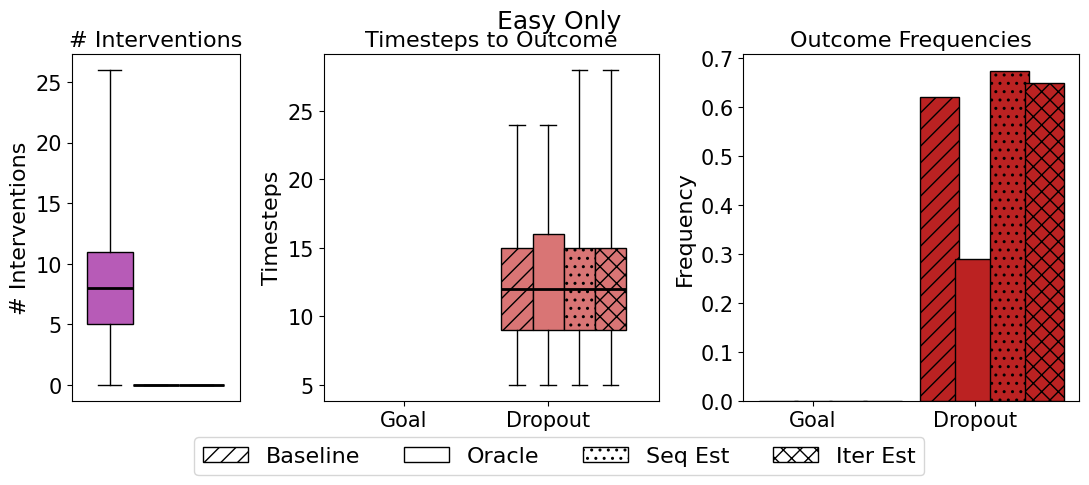

/content/_notebook_code/vis_inter_stats_w_stuck_est.py:579: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0.06, 0.99, 0.98])


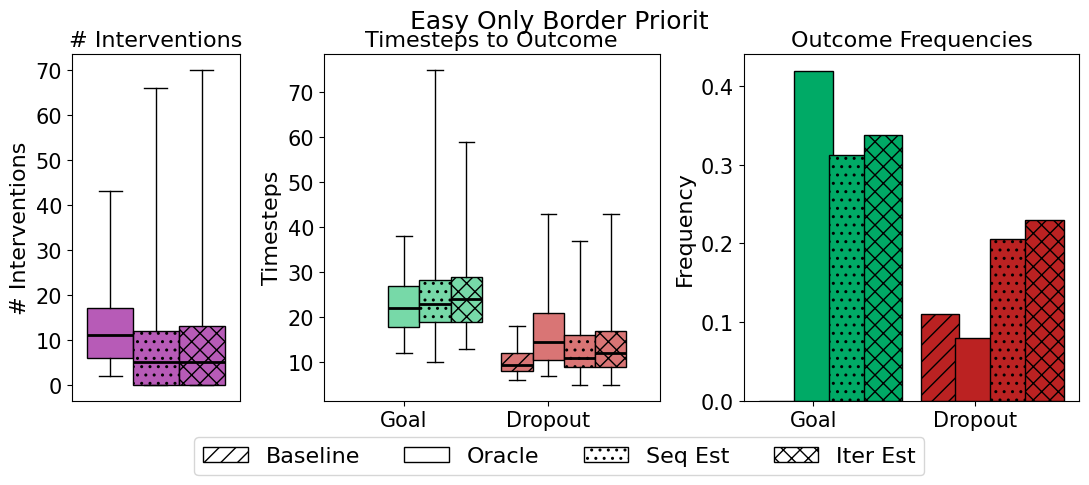

/content/_notebook_code/vis_inter_stats_w_stuck_est.py:579: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0.06, 0.99, 0.98])


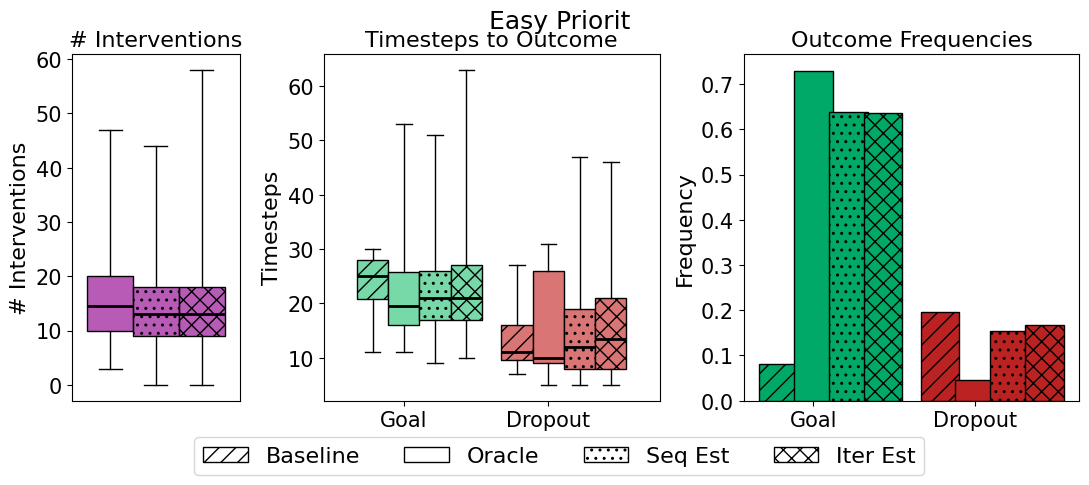

/content/_notebook_code/vis_inter_stats_w_stuck_est.py:579: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0.06, 0.99, 0.98])


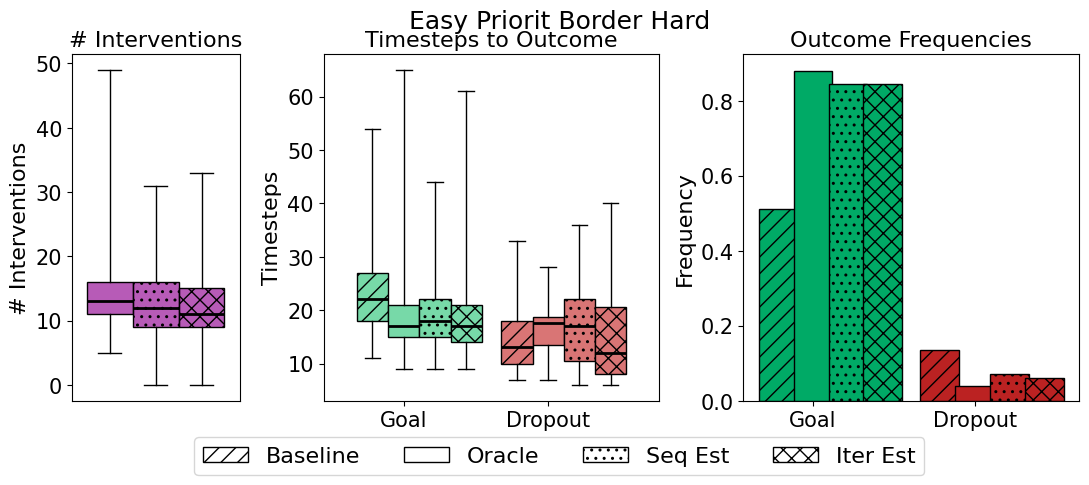

/content/_notebook_code/vis_inter_stats_w_stuck_est.py:579: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0.06, 0.99, 0.98])


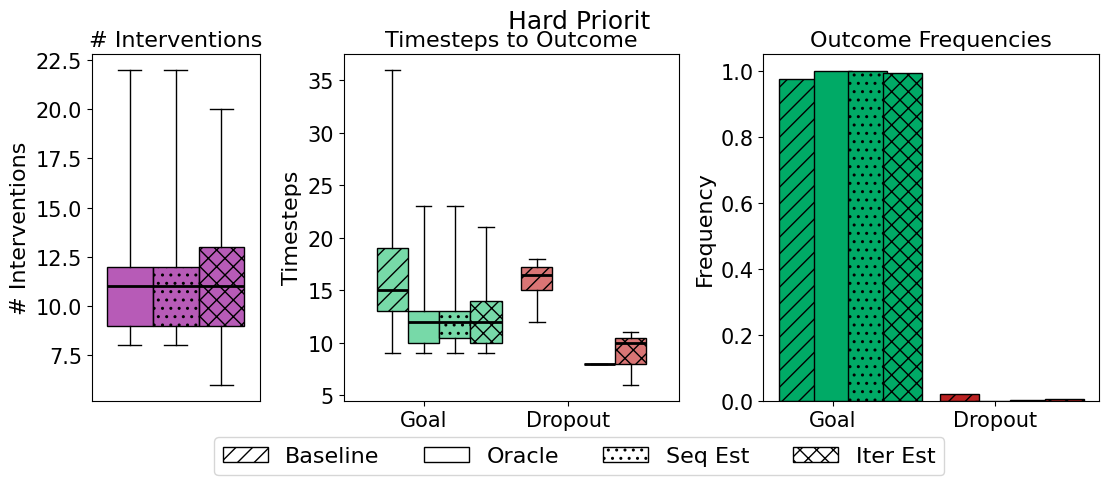

In [54]:
# Reproducing impact of disengagement estimation
# Plotting iter and seq estimators v oracle AI v human
configs = [
    {"label": "Easy Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Easy Only Border Priorit",  "p_fwd_chain_1": 0.2,  "p_fwd_chain_2": 0.4, "p_fwd_stuck": 0.4},
    {"label": "Easy Priorit", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Easy Priorit Border Hard", "p_fwd_chain_1": 0.4, "p_fwd_chain_2": 0.5,  "p_fwd_stuck": 0.4},
    {"label": "Easy Priorit Border Hard Closer", "p_fwd_chain_1": 0.5, "p_fwd_chain_2": 0.7,  "p_fwd_stuck": 0.4},
    {"label": "Hard Priorit", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4}
]


# dataframe containing stats under estimating the disengagement state
df_est = pd.read_csv(os.path.join("notebook_results", "disengage_est", "human_ai_est_stats_policy_classes" + "_w_disengage_est.csv"))
# dataframe containing stats for oracle AI (which knows disengagement state)
df_base = pd.read_csv(os.path.join("notebook_results", "ai", "human_ai_stats_policy_classes" + "_w_inter.csv"))



# Merge the dataframes together on p_fwd_chain_1, p_fwd_chain_2, p_fwd_stuck
# (which uniquely define rows), do not keep redundant columns

# Step 1: Define merge keys
merge_keys = ["p_fwd_chain_1", "p_fwd_chain_2", "p_fwd_stuck"]

# Step 2: Select only _iter and _seq columns + merge keys from df_extra
iter_seq_cols = [col for col in df_est.columns if '_iter' in col or '_seq' in col]
df_extra_subset = df_est[merge_keys + iter_seq_cols]

for col in merge_keys:
    df_base[col] = df_base[col].round(6)
    df_est[col] = df_est[col].round(6)

# Step 3: Merge into the main DataFrame on the keys
df_merged = df_base.merge(df_extra_subset, on=merge_keys, how='left')


# Set up saving folder
if not os.path.isdir(os.path.join("notebook_figures", "disengage_est")):
    os.makedirs(os.path.join("notebook_figures", "disengage_est"))

# Now make visualizations
config = configs[0]
save_path = os.path.join("notebook_figures", "disengage_est", "easy-only-compar-seq-iter.png")
plot_n_inters_ts_outcome_freq_outcome_compar_seq_iter(df_merged, config, save_path=save_path, use_suptitle=True)

config = configs[1]
save_path = os.path.join("notebook_figures", "disengage_est", "easy-only-border-prior-compar-seq-est.png")
plot_n_inters_ts_outcome_freq_outcome_compar_seq_iter(df_merged, config, save_path=save_path, use_suptitle=True)

config = configs[2]
save_path = os.path.join("notebook_figures", "disengage_est", "easy-prior-compar-seq-iter.png")
plot_n_inters_ts_outcome_freq_outcome_compar_seq_iter(df_merged, config, save_path=save_path, use_suptitle=True)

config = configs[3]
save_path = os.path.join("notebook_figures", "disengage_est", "easy-prior-border-hard-compar-seq-iter.png")
plot_n_inters_ts_outcome_freq_outcome_compar_seq_iter(df_merged, config, save_path=save_path, use_suptitle=True)

config = configs[5]
save_path = os.path.join("notebook_figures", "disengage_est", "hard-prior-compar-seq-iter.png")
plot_n_inters_ts_outcome_freq_outcome_compar_seq_iter(df_merged, config, save_path=save_path, use_suptitle=True)

## Model-free learning fails to personalize in the MHBC setting

Sampling AI trajectories under Q-learning, as well as saving data for examining impact of Q-learning on AI's ability to help the human agent.

In [ ]:
"""
Use Q-learning to learn AI policy.  Environment created from human MDP.
Gets results when AI has access to all intervnetion actions, with intervention
of p_fwd_stuck dec by 0.2 under intervention, as well as intervention of
p_fwd_chain1 and p_fwd_chain2 inc by 0.2 under intervention.  Can run for multiple
different human MDP setups.  Records stats of discounted cumulative rewards,
making it to the goal, ends of chains, and dropping out.

NOTE: the AI can take the following actions:
0: do nothing
1: reduce probability of moving forward on the stuck chain
2: increase probability of moving forward on chain 1
3: increase probability of moving forward on chain 2

NOTE: uses decay of epsilon only between episodes, which was found
to work better.  Uses the learning rate found to perform ideally
on the easy prioritization policy.
"""
def mk_run_progchainworld_q_learning(chain_1_dim, chain_2_dim, stuck_chain_dim,
                          p_fwd_chain_1, p_fwd_chain_2,
                          relapse_chain_1, relapse_chain_2,
                          p_fwd_stuck, p_back_stuck,
                          p_fwd_chain1_intervention, p_fwd_chain2_intervention,
                          p_fwd_stuck_intervention,
                          r_goal, r_dropout, r_intervention,
                          num_ai_actions,
                          print_none,
                          num_trials, num_episodes, max_n_steps_per_rollout,
                          gamma, delta_vi,
                          df, iteration, df_label,
                          save_folder, save_file,
                          kappa, min_epsilon, init_epsilon, lr=0.15):
    """
    Helper function for instantiating a human multiprogress chainworld
    and AI agent and repeatedly sampling AI-human trajectories from it
    under episodic Q-learning.
    Logs metrics and statistics from sampled trajectory to a df.

    Parameters:
    -----------
    chain_1_dim, chain_2_dim, stuck_chain_dim: ints
        length of progress chain 1, progress chain 2, and disengagement chain
    p_fwd_chain_1, p_fwd_chain_2, relapse_chain_1, relapse_chain_2: floats in [0, 1]
        f_1, f_2, b_1, b_2 as defined in paper
    p_fwd_stuck, p_back_stuck: floats in [0, 1]
        f_d, b_d as defined in paper
    p_fwd_chain1_intervention, p_fwd_chain2_intervention, p_fwd_stuck_intervention: floats in [0, 1]
        f_1 + \Delta_{AI}, f_2 + \Delta_{AI}, f_d - \Delta_{AI} (f_1, f_2, and f_d
        under AI intervention on progress chain 1, progress chain 2, and disengagement
        chain, respectively)
    r_goal, r_dropout, r_intervention: floats
        r_g, r_d, r_{inter} as defined in paper: reward for reaching goal state s_g and 
        dropout state s_d, and reward (cost) of AI intervention, respectively
    num_ai_actions: int
        number of possible AI actions (should be 4: do nothing, intervene on disengagement
        chain, intervene on progress chain 1, intervene on progress chain 2)
    print_none: bool
        if True: silences print to speed up running code
    num_trials, num_episodes, max_n_steps_per_rollout: ints
        for num_trials iterations, samples num_episodes episodes of length 
        max_n_steps_per_rollout timesteps.
    df, iteration: pd.DataFrame, int
        DataFrame to append data to (should have column names of 'column_names' variable
        in the cell block below),
        iteration of sampling trajectories
    df_label, save_folder, save_file: strs
        policy class to label DataFrame containing trajectory data with (prepends
        to save_file name)--this is the policy class for which trajectories under
        episodic Q-learning are being sampled,
        directory and .csv file name to save the logged statistics from sampling
        trajectories to (logged in the inputted df)
    """
    if not print_none:
        print("Probability of moving forward on chain 1 is {}\n".format(p_fwd_chain_1))
        print("Probability of moving forward on chain 2 is {}\n".format(p_fwd_chain_2))
        print("Probability of relapse when don't move forward on chain 1 is {}\n".format(relapse_chain_1))
        print("Probability of relapse when don't move forward on chain 2 is {}\n".format(relapse_chain_2))
        print(f"Probability of moving fwd on stuck chain: {p_fwd_stuck}")
        print(f"Probability of moving back on stuck chain: {p_back_stuck}")
        print(f"Probability of moving fwd on stuck chain under its intervention: {p_fwd_stuck_intervention}")

    # Set up parameters
    prog_chain_dims = [chain_1_dim, chain_2_dim]
    p_fwd_prog_chains = [p_fwd_chain_1, p_fwd_chain_2]
    p_back_prog_chains = [relapse_chain_1, relapse_chain_2]

    p_fwd_prog_chains_intervention_chain1 = [p_fwd_chain1_intervention, p_fwd_chain_2]
    p_fwd_prog_chains_intervention_chain2 = [p_fwd_chain_1, p_fwd_chain2_intervention]

    # Make human transition matrices (for baseline and each intervention)
    T_human = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    T_human_intervention_stuck = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                    p_fwd_prog_chains=p_fwd_prog_chains, p_back_prog_chains=p_back_prog_chains,
                                    p_fwd_stuck=p_fwd_stuck_intervention, p_back_stuck=p_back_stuck)

    T_human_intervention_chain1 = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                 p_fwd_prog_chains=p_fwd_prog_chains_intervention_chain1,
                                 p_back_prog_chains=p_back_prog_chains,
                                 p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    T_human_intervention_chain2 = make_nchains_transitions_simplified(prog_chain_dims=prog_chain_dims, stuck_chain_dim=stuck_chain_dim,
                                 p_fwd_prog_chains=p_fwd_prog_chains_intervention_chain2,
                                 p_back_prog_chains=p_back_prog_chains,
                                 p_fwd_stuck=p_fwd_stuck, p_back_stuck=p_back_stuck)

    # Make human reward matrix
    R_human = make_rewards_stuck(chain_1_dim=chain_1_dim, chain_2_dim=chain_2_dim,
                    stuck_chain_dim=stuck_chain_dim, r_goal=r_goal,
                    r_dropout=r_dropout)

    # Solve for optimal human policies
    pi_human, Q_human, V_human = value_iteration(T_human, R_human, gamma, delta=delta_vi)
    pi_human_intervention_stuck, Q_human_intervention_stuck, V_human_intervention_stuck = value_iteration(T_human_intervention_stuck, R_human, gamma, delta=delta_vi)
    pi_human_intervention_chain1, Q_human_intervention_chain1, V_human_intervention_chain1 = value_iteration(T_human_intervention_chain1, R_human, gamma, delta=delta_vi)
    pi_human_intervention_chain2, Q_human_intervention_chain2, V_human_intervention_chain2 = value_iteration(T_human_intervention_chain2, R_human, gamma, delta=delta_vi)

    # Start creating AI transition matrix
    # have one transition matrix per intervention action AI does (first is no intervention)
    # and optimal human policy learned for that transition matrix
    T_humans = [T_human, T_human_intervention_stuck, T_human_intervention_chain1, T_human_intervention_chain2]
    pi_humans = [pi_human, pi_human_intervention_stuck, pi_human_intervention_chain1, pi_human_intervention_chain2]

    # Create AI agent which can perform all intervention actions
    # create AI transition matrix: uses human transitions corresponding to action AI took
    # can only transition to a state via an action the corresponding human policy states
    T_AI = build_T_ai(T_humans=T_humans, pi_humans=pi_humans, multi_hot_pis=True)

    # create AI reward matrix
    R_AI = build_R_ai(num_ai_actions, R_human, prog_chain_dims, stuck_chain_dim, r_goal, r_dropout, r_intervention)

    # Get AI Q shape (will instantiate it with zeros)
    _, Q, _ = value_iteration(T_AI, R_AI, gamma)

    # Num states in human action space = do no work + work on each progress chain i
    A_h = len(prog_chain_dims) + 1
    # AI states consist of tuples of form (s_h, a_h), a_h is human action
    chain_dims = prog_chain_dims + [stuck_chain_dim]
    AI_state_dims = chain_dims + [A_h]

    if not os.path.isdir(save_folder):
        os.makedirs(save_folder)

    # Human under AI intervention policy using Q learning
    # now sample trajectory:
    # start at (0, 0, 0), no prior action taken (set default one of 0--doesn't matter
    # bc the action from the step b4 doesn't matter when trying to find prob of transition
    # to next state from current state)
    start_state = (0, 0, 0, 0)
    for n in range(num_trials):
        init_Q = np.zeros((Q.shape))
        epsilon = init_epsilon
        for episode in range(num_episodes):
            mk_goal_q = 0 # 0 means did not mk goal
            dropout_q = 0
            mk_end_c1_q = 0
            mk_end_c2_q = 0
            n_interventions_q = 0
            AI_rwds_q = 0 # each element is the sum of the accumulated AI rewards
            n_human_actions_q = 0
            human_rwds_q = 0
            n_ts_to_end_c1_q = np.nan
            n_ts_to_end_c2_q = np.nan
            n_ts_to_goal_q = np.nan
            n_ts_to_dropout_q = np.nan

            traj_states, traj_actions, init_Q, total_AI_rwd = sample_traj_q_learning_episodic_decay(T_AI, init_Q, R_AI, start_state, AI_state_dims,
                                                               num_ai_actions, epsilon=epsilon,
                                                               n_steps=max_n_steps_per_rollout,
                                                               alpha=lr)

            # Collect stats
            # convert trajectory state indices to tuples (is of form (s_h, a_h))
            traj_states_tuples = [index_to_state(state_idx, AI_state_dims) for state_idx in traj_states]

            # a: prog chain 1 state, b: prog chain 2 state: c: stuck chain state, d: human action at prev state
            hit_goal = any(a == chain_1_dim-1 and b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
            if hit_goal:
                mk_goal_q += 1
                hit_dropout = False
            else:
                # put in else since can hit goal and dropout simultaneously, but we count
                # that as hitting the goal
                hit_dropout = any(c == stuck_chain_dim - 1 for a, b, c, d in traj_states_tuples)
                if hit_dropout:
                    dropout_q +=1

            # number of AI intervention actions
            n_interventions_q = np.sum(traj_actions > 0)
            # number of human actions in human trajectory under AI intervention
            n_human_actions_q = len(traj_actions)
            # AI rwds
            AI_rwds_q = total_AI_rwd

            # human under AI rewards (need to split AI states into the
            # human states and actions)
            human_cumulative_reward = 0
            for i in range(1, len(traj_states)):
                prog_1_prev_state, prog_2_prev_state, stuck_prev_state, _ = traj_states_tuples[i-1]
                prog_1_next_state, prog_2_next_state, stuck_next_state, prev_human_action = traj_states_tuples[i-1]
                prev_state_idx = state_to_index((prog_1_prev_state, prog_2_prev_state, stuck_prev_state), dim_sizes=chain_dims)
                next_state_idx = state_to_index((prog_1_next_state, prog_2_next_state, stuck_next_state), dim_sizes=chain_dims)
                human_cumulative_reward += (gamma**(i-1)) * R_human[prev_state_idx, prev_human_action, next_state_idx]
            human_rwds_q = human_cumulative_reward

            # check whether mk end progress chain 1
            hit_end_prog_1 = any(a == chain_1_dim-1 for a, b, c, d in traj_states_tuples)
            mk_end_c1_q += hit_end_prog_1
            # check whether mk end progress chain 2
            hit_end_prog_2 = any(b == chain_2_dim-1 for a, b, c, d in traj_states_tuples)
            mk_end_c2_q += hit_end_prog_2

            # num ts to end c1 (if applicable)
            if hit_end_prog_1:
                # gets the first timestep got to the end of chain 1 (counting from 1)
                num_ts_to_end_c1 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1)
                n_ts_to_end_c1_q = num_ts_to_end_c1
            # num ts to end c2 (if applicable)
            if hit_end_prog_2:
                # gets the first timestep got to the end of chain 1 (counting from 1)
                num_ts_to_end_c2 = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if b == chain_2_dim - 1)
                n_ts_to_end_c2_q = num_ts_to_end_c2
            # num ts to goal (if applicable)
            if hit_goal:
                num_ts_to_goal = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if a == chain_1_dim - 1 and b == chain_2_dim - 1)
                n_ts_to_goal_q = num_ts_to_goal
            # num ts to dropout (if applicable)
            elif hit_dropout:
                num_ts_to_dropout = 1 + next(i for i, (a, b, c, d) in enumerate(traj_states_tuples) if c == stuck_chain_dim - 1)
                n_ts_to_dropout_q = num_ts_to_dropout


            # Easier chain to get to end of is one with higher p_fwd) bc set
            # up both to have same p_back), determine which that is
            if p_fwd_chain_1 >= p_fwd_chain_2:
                # chain 1 is easier chain to work on
                mk_end_easier_q = mk_end_c1_q
                mk_end_harder_q = mk_end_c2_q
                n_ts_to_end_easier_q = n_ts_to_end_c1_q
                n_ts_to_end_harder_q = n_ts_to_end_c2_q
            else:
                # chain 2 is easier chain to work on
                mk_end_easier_q = mk_end_c2_q
                mk_end_harder_q = mk_end_c1_q
                n_ts_to_end_easier_q = n_ts_to_end_c2_q
                n_ts_to_end_harder_q = n_ts_to_end_c1_q

            # Create rows of dataframe
            new_row = [n, episode, chain_1_dim, chain_2_dim,
                    p_fwd_chain_1, p_fwd_chain1_intervention,
                    p_fwd_chain_2, p_fwd_chain2_intervention,
                    relapse_chain_1, relapse_chain_2,
                    p_fwd_stuck, p_fwd_stuck_intervention, p_back_stuck,
                    mk_goal_q, dropout_q, mk_end_easier_q, mk_end_harder_q,
                    n_interventions_q, AI_rwds_q, n_human_actions_q,
                    human_rwds_q, n_ts_to_end_easier_q, n_ts_to_end_harder_q,
                    n_ts_to_goal_q, n_ts_to_dropout_q
                ]

            # replace row at current iteration
            df.iloc[iteration] = new_row
            # save dataframe every 10 iters
            if iteration % 20000 == 0:
                df.to_csv(os.path.join(save_folder, df_label + "_" + save_file + "_q_learn.csv"))
                print(f"iteration: {iteration}")

            # Set up for next iteration, decaying epsilon per episode
            epsilon = max(min_epsilon, epsilon * kappa)
            iteration += 1

In [ ]:
# Runner code
# Folder to save policies to
save_folder = os.path.join("notebook_results", "q_learning")
save_file = "q_learning_stats"

# Set up human and AI rewards
r_goal = 10 # Reward for reaching end of both progress chains
r_dropout = -10 # Cost for dropping out
r_intervention = -0.1 # AI agent's cost for intervening

print_none = True # if True, prints nothing

# Progchain world parameters: chain lengths
chain_1_dim = 5
chain_2_dim = 5
stuck_chain_dim = 5

# Set index of last state on each chain
chain_1_goal = chain_1_dim - 1
chain_2_goal = chain_2_dim - 1
end_stuck = stuck_chain_dim - 1

gamma = 0.9 # discount factor for value iteration (VI)
delta_vi = 1e-4 # threshold to stop VI at

num_ai_actions = 4 # see list of actions in file header

# Sampling parameters
num_trials = 100
num_episodes = 1000
max_n_steps_per_rollout = 80

# Q-learning parameters
init_epsilon = 1.
min_epsilon = 0.1
kappa =  0.995 # multiplicative factor by which to decay epsilon per episode


if not print_none:
    print(f"Discount factor is: {gamma}")
    print(f"Threshold (delta) for VI is: {delta_vi}")
    print("Progchainworld parameters:")
    print("Prochainworld chain dimensions are {}, {}".format(chain_1_dim, chain_2_dim, stuck_chain_dim))
    print("Absorbing goal is at ({}, {}) with human value {}, AI value {}".format(chain_1_goal, chain_2_goal, r_goal, r_goal))
    print("Absorbing dropout state is at {} with human value {}, AI value {}".format(end_stuck, r_dropout, r_dropout))


column_names = ["trial", "episode", 'chain_1_dim', 'chain_2_dim',
                    'p_fwd_chain_1', 'p_fwd_chain_1_inter',
                    'p_fwd_chain_2', 'p_fwd_chain_2_inter',
                    'relapse_chain_1', 'relapse_chain_2',
                    'p_fwd_stuck', 'p_fwd_stuck_inter', 'p_back_stuck',
                    'mk_goal_q', 'dropout_q', 'mk_end_easier_q', 'mk_end_harder_q',
                    'n_interventions_q', 'AI_rwds_q', 'n_human_actions_q',
                    'human_rwds_q', 'n_ts_to_end_easier_q', 'n_ts_to_end_harder_q',
                    'n_ts_to_goal_q', 'n_ts_to_dropout_q'
                ]


configs = [
    {"label": "Easy-Only",  "p_fwd_chain_1": 0.1,  "p_fwd_chain_2": 0.2, "p_fwd_stuck": 0.4},
    {"label": "Hard-Prior", "p_fwd_chain_1": 0.6, "p_fwd_chain_2": 0.8, "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior", "p_fwd_chain_1": 0.3, "p_fwd_chain_2": 0.4,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Prior-Border-Hard", "p_fwd_chain_1": 0.4, "p_fwd_chain_2": 0.5,  "p_fwd_stuck": 0.4},
    {"label": "Easy-Only-Border-Priorit",  "p_fwd_chain_1": 0.2,  "p_fwd_chain_2": 0.4, "p_fwd_stuck": 0.4}
]

relapse_chain_1 = 0.3
relapse_chain_2 = 0.3
p_back_stuck = 0.5

lr = 0.15 # in between best two learning rates

for config in configs:
    iteration = 0  # starting over in new df
    df = pd.DataFrame(np.zeros((num_trials * num_episodes, len(column_names))), columns=column_names)
    p_fwd_chain_1 = config["p_fwd_chain_1"]
    p_fwd_chain_2 = config["p_fwd_chain_2"]
    p_fwd_stuck = config["p_fwd_stuck"]
    df_label = config["label"]
    print(f"config label: {df_label}")

    # did delta 0.2 so can match up to human baseline (bc skipped by 0.2 for p_fwd_stuck
    # in results where vary that one)
    p_fwd_stuck_intervention = max(0, p_fwd_stuck - 0.2)
    # did delta 0.2 to match w stuck intervention
    p_fwd_chain1_intervention = min(1, p_fwd_chain_1 + 0.2)
    p_fwd_chain2_intervention = min(1, p_fwd_chain_2 + 0.2)


    mk_run_progchainworld_q_learning(chain_1_dim, chain_2_dim, stuck_chain_dim,
                          p_fwd_chain_1, p_fwd_chain_2,
                          relapse_chain_1, relapse_chain_2,
                          p_fwd_stuck, p_back_stuck,
                          p_fwd_chain1_intervention, p_fwd_chain2_intervention,
                          p_fwd_stuck_intervention,
                          r_goal, r_dropout, r_intervention,
                          num_ai_actions,
                          print_none,
                          num_trials, num_episodes, max_n_steps_per_rollout,
                          gamma, delta_vi,
                          df, iteration, df_label,
                          save_folder, save_file,
                          kappa, min_epsilon, init_epsilon, lr)

    df.to_csv(os.path.join(save_folder, df_label + "_" + save_file + "_q_learn.csv"))

config label: Easy-Only
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
config label: Hard-Prior
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
config label: Easy-Prior
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
config label: Easy-Prior-Border-Hard
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000
config label: Easy-Only-Border-Priorit
iteration: 0
iteration: 20000
iteration: 40000
iteration: 60000
iteration: 80000


Visualizing the impact of Q-learning on AI's ability to help the human agent as compared to the AI oracle and AI under disengagement estimation.

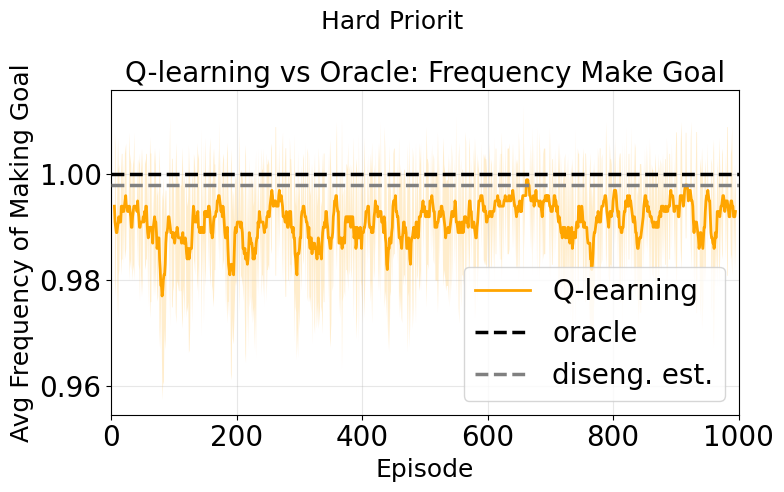

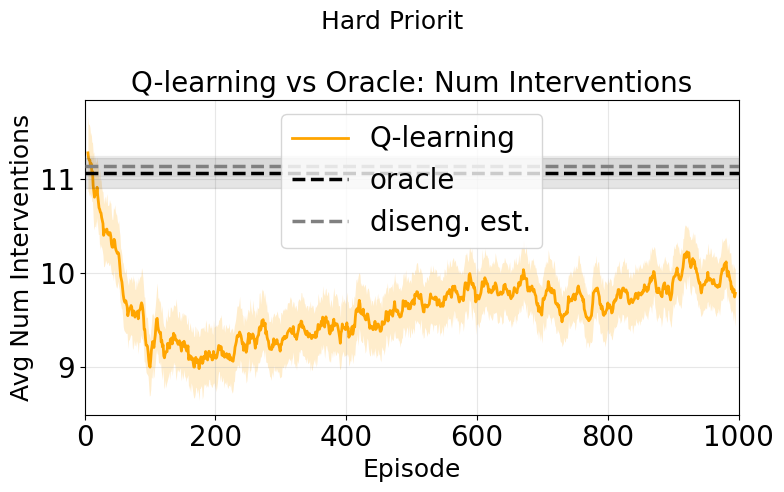

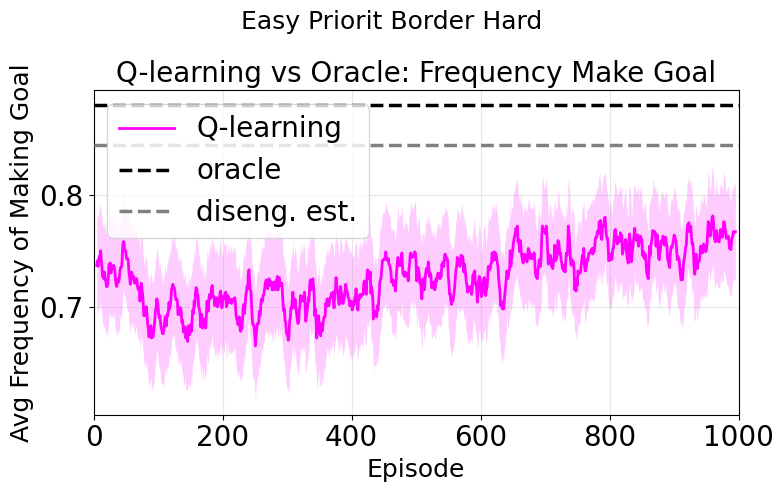

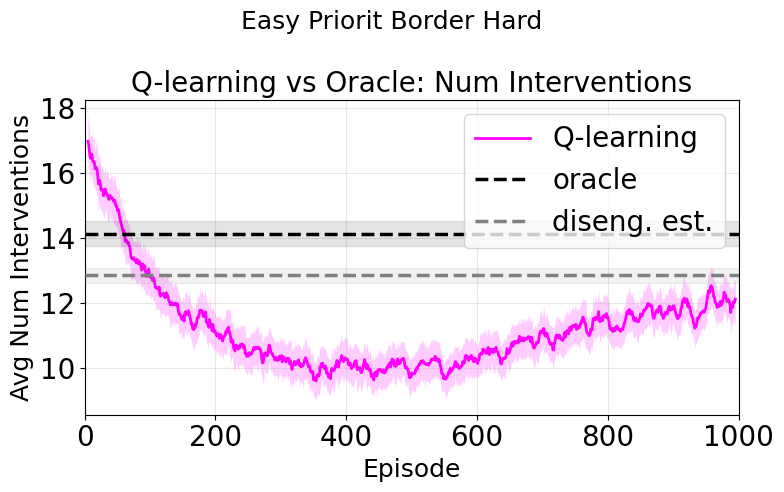

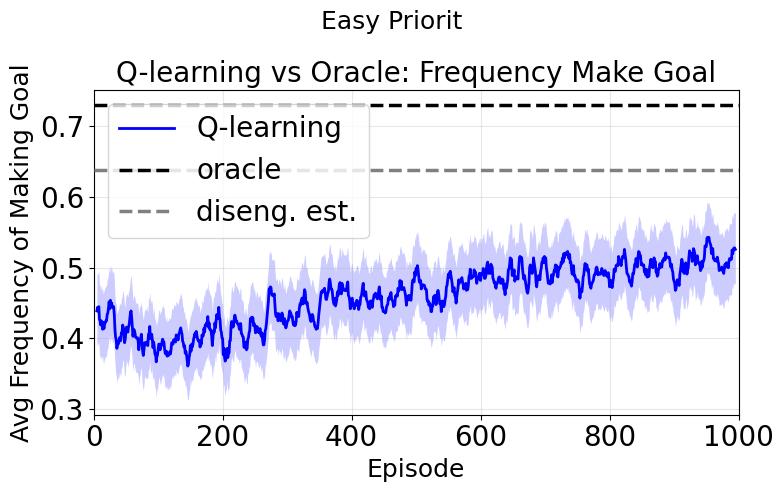

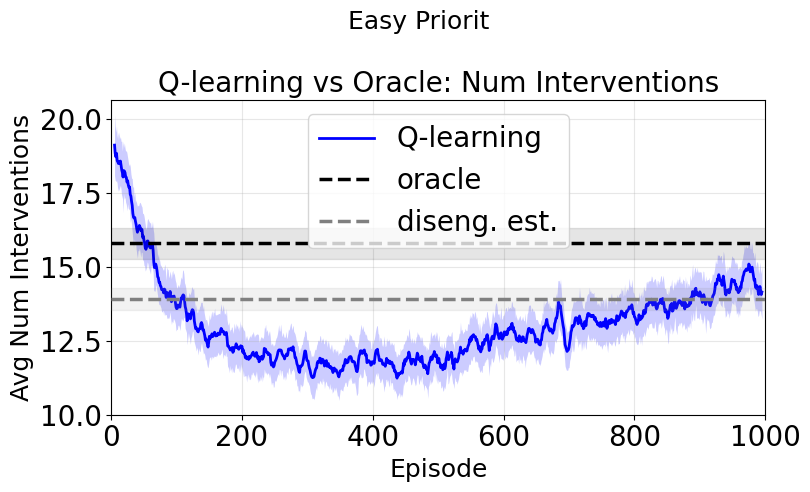

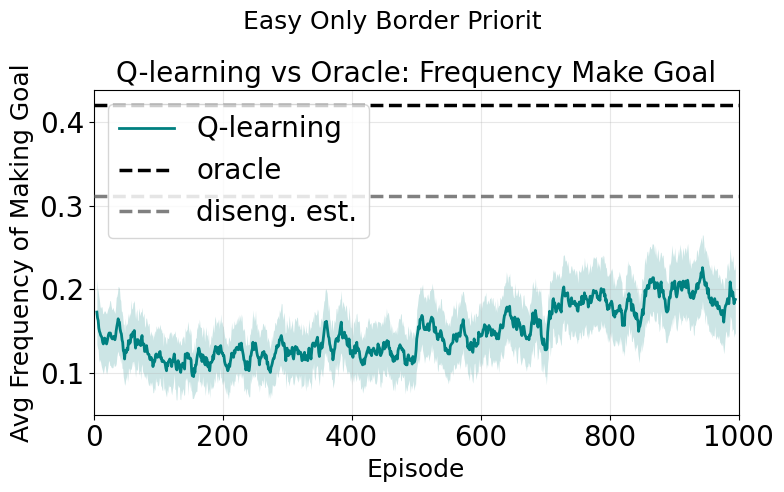

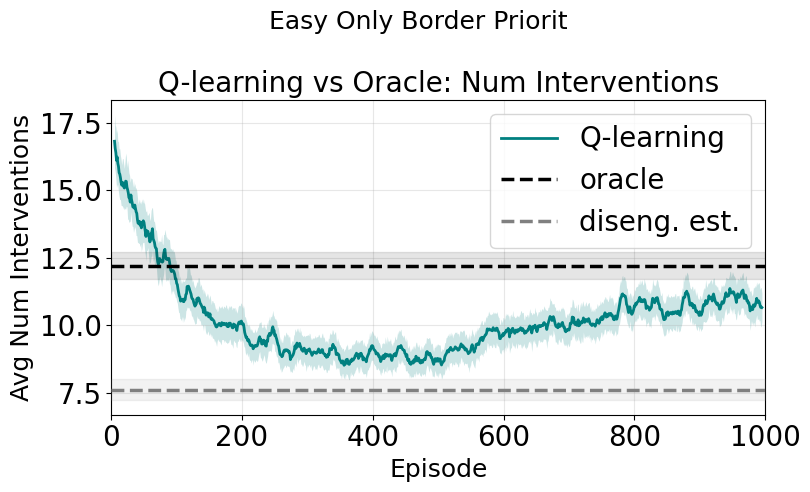

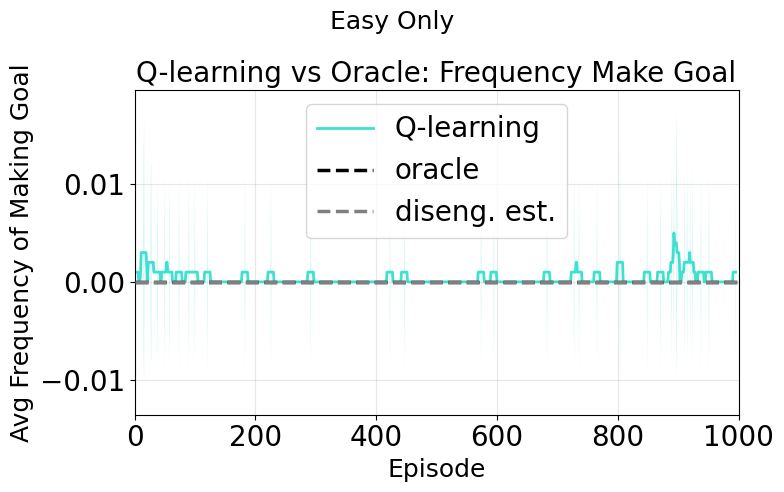

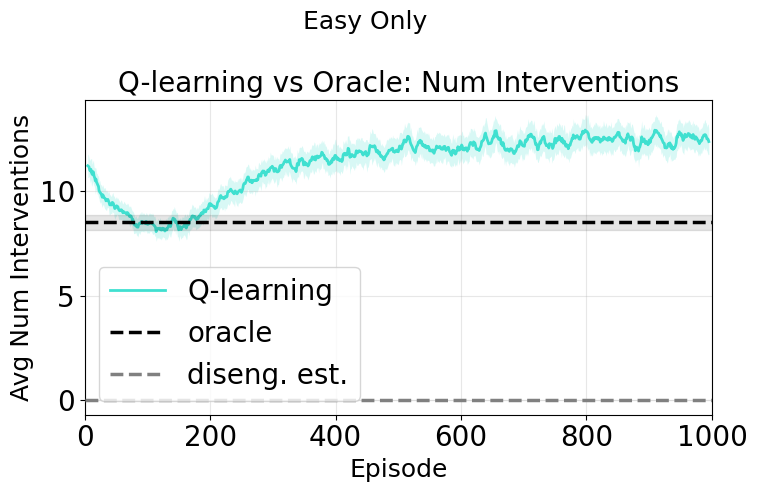

In [57]:
# Reproducing Q-learning results: creating the visualizations
data_folder = os.path.join("notebook_results", "q_learning")
data_file = "q_learning_stats"

dfs_by_pol = {
    "Easy Only": pd.read_csv(os.path.join(data_folder, "Easy-Only_" + data_file + "_q_learn.csv")),
    "Easy Only Border Priorit": pd.read_csv(os.path.join(data_folder, "Easy-Only-Border-Priorit_" + data_file + "_q_learn.csv")),
    "Easy Priorit": pd.read_csv(os.path.join(data_folder, "Easy-Prior_" + data_file + "_q_learn.csv")),
    "Easy Priorit Border Hard": pd.read_csv(os.path.join(data_folder, "Easy-Prior-Border-Hard_" + data_file + "_q_learn.csv")),
    "Hard Priorit": pd.read_csv(os.path.join(data_folder, "Hard-Prior_" + data_file + "_q_learn.csv"))
}

oracle_folder = os.path.join("notebook_results", "ai")
oracle_file = "human_ai_stats_policy_classes"
oracle = pd.read_csv(os.path.join(oracle_folder, oracle_file + "_w_inter.csv"))


disengage_est_folder = os.path.join("notebook_results", "disengage_est")
disengage_est_file = "human_ai_est_stats_policy_classes"
disengagement_est = pd.read_csv(os.path.join(disengage_est_folder, disengage_est_file + "_w_disengage_est.csv"))

save_folder = os.path.join("notebook_figures", "q_learning")
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

# Create visualizations
# Hard prior
p1 = 0.6
p2 = 0.8
ps = 0.4
color = "orange"
suptitle = "Hard Priorit"
q_df = dfs_by_pol[suptitle]
save_path = os.path.join(save_folder, "freq_goal_compar_hard-prior")
plot_qlearning_v_oracle_stuck_freq_mk_goal(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)
save_path = os.path.join(save_folder, "n_interventions_compar_hard-prior")
plot_qlearning_v_oracle_stuck_n_interventions(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)

# Easy prior border hard
p1 = 0.4
p2 = 0.5
ps = 0.4
color = "magenta"
suptitle = "Easy Priorit Border Hard"
q_df = dfs_by_pol[suptitle]
save_path = os.path.join(save_folder, "freq_goal_compar_easy-prior-border-hard")
plot_qlearning_v_oracle_stuck_freq_mk_goal(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)
save_path = os.path.join(save_folder, "n_interventions_compar_easy-prior-border-hard")
plot_qlearning_v_oracle_stuck_n_interventions(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)

# Easy prior # biggest gap, and most important test case
p1 = 0.3
p2 = 0.4
ps = 0.4
color = "blue"
suptitle = "Easy Priorit"
q_df = dfs_by_pol[suptitle]
save_path = os.path.join(save_folder, "freq_goal_compar_easy-prior")
plot_qlearning_v_oracle_stuck_freq_mk_goal(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)
save_path = os.path.join(save_folder, "n_interventions_compar_easy-prior")
plot_qlearning_v_oracle_stuck_n_interventions(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)

# Easy only border prior
p1 = 0.2
p2 = 0.4
ps = 0.4
color = "teal"
suptitle = "Easy Only Border Priorit"
q_df = dfs_by_pol[suptitle]
save_path = os.path.join(save_folder, "freq_goal_compar_easy-only-border-prior")
plot_qlearning_v_oracle_stuck_freq_mk_goal(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)
save_path = os.path.join(save_folder, "n_interventions_compar_easy-only-border-prior")
plot_qlearning_v_oracle_stuck_n_interventions(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)

# Easy only
p1 = 0.1
p2 = 0.2
ps = 0.4
color = "turquoise"
suptitle = "Easy Only"
q_df = dfs_by_pol[suptitle]
save_path = os.path.join(save_folder, "freq_goal_compar_easy-only")
plot_qlearning_v_oracle_stuck_freq_mk_goal(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)
save_path = os.path.join(save_folder, "n_interventions_compar_easy-only")
plot_qlearning_v_oracle_stuck_n_interventions(q_df, oracle, disengagement_est, p1, p2, ps, color, savepath=save_path, suptitle=suptitle)

The end.